# New York City taxi fair

## 1. Library とデータの読み込み

In [1]:
import os
import gc
import sys # Pythonのインタプリタや実行環境に関する情報を扱うためのライブラリ
import pandas as pd # データを扱うための標準的なライブラリ
import numpy as np # 多次元配列を扱う数値演算ライブラリ
import scipy as sp # 高度な科学計算を行うためのライブラリ
import sklearn # 機械学習のライブラリ

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor as RFR
import lightgbm as lgb  #conda install -c conda-forge lightgbm
import xgboost as xgb    # conda install -c anaconda py-xgboost
from catboost import CatBoost
from catboost import Pool

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

import matplotlib.pyplot as plt # グラフを描画するライブラリ
import seaborn as sns
%matplotlib inline 
# jupyter内に描画

import time # 処理時間計測用

### Cleansed data を読み込む

In [2]:
df = pd.read_csv("./data/df_cleansed.csv")
df.head()

key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [3]:
df.shape

(489399, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489399 entries, 0 to 489398
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                489399 non-null  object 
 1   fare_amount        489399 non-null  float64
 2   pickup_datetime    489399 non-null  object 
 3   pickup_longitude   489399 non-null  float64
 4   pickup_latitude    489399 non-null  float64
 5   dropoff_longitude  489399 non-null  float64
 6   dropoff_latitude   489399 non-null  float64
 7   passenger_count    489399 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 29.9+ MB


In [5]:
# 欠損値のカウント
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [6]:
# fair_amount の上限と下限
print("Minimum fair: ", min(df.fare_amount))
print("Maximun fair: ", max(df.fare_amount))

Minimum fair:  -44.9
Maximun fair:  500.0


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 1.80000e+01, 2.98839e+05,
        1.43577e+05, 2.51140e+04, 9.78700e+03, 7.45300e+03, 3.62600e+03,
        4.07000e+02, 2.65000e+02, 1.01000e+02, 6.20000e+01, 3.40000e+01,
        3.90000e+01, 1.60000e+01, 1.50000e+01, 1.00000e+01, 5.00000e+00,
        3.00000e+00, 2.00000e+00, 7.00000e+00, 6.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

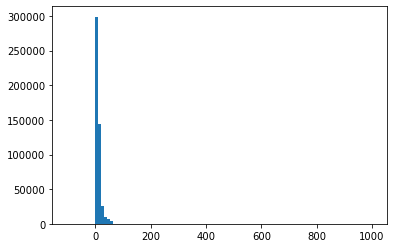

In [7]:
# fare_amount の棒グラフ --> 全領域
plt.hist(df.fare_amount, bins=100, range=(-100, 1000))

In [8]:
# fare_amount の棒グラフ 
plt.hist(df.fare_amount, bins=100, range=(0, 60))

(array([1.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8350e+03,
        7.0710e+03, 2.2531e+04, 2.0491e+04, 3.7631e+04, 2.4539e+04,
        4.8006e+04, 2.3302e+04, 3.3344e+04, 2.0191e+04, 2.7301e+04,
        2.4271e+04, 2.0898e+04, 1.2529e+04, 1.6257e+04, 1.0040e+04,
        1.7423e+04, 7.6100e+03, 9.9670e+03, 6.1060e+03, 7.8170e+03,
        7.8240e+03, 6.1630e+03, 4.0700e+03, 4.8820e+03, 3.2320e+03,
        5.7020e+03, 2.5730e+03, 3.0950e+03, 2.1580e+03, 2.5390e+03,
        2.7800e+03, 1.9370e+03, 1.3650e+03, 1.7110e+03, 1.2260e+03,
        2.1770e+03, 1.1780e+03, 1.3680e+03, 1.0680e+03, 1.3100e+03,
        1.3590e+03, 1.1930e+03, 1.0400e+03, 1.1790e+03, 8.8200e+02,
        1.2090e+03, 9.0400e+02, 9.4600e+02, 9.8600e+02, 8.5000e+02,
        8.3100e+02, 7.7100e+02, 5.9400e+02, 7.8900e+02, 5.5500e+02,
        6.5500e+02, 4.7300e+02, 4.8300e+02, 5.2500e+02, 4.0800e+02,
        4.2700e+02, 3.6700e+02, 2.7200e+02, 4.1300e+02, 2.2600e+02,
        3.1500e+02, 2.2200e+02, 2.1900e+02, 2.37

(array([1.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.7070e+03, 0.0000e+00, 0.0000e+00, 1.1280e+03, 0.0000e+00,
        9.0100e+02, 0.0000e+00, 3.7500e+03, 1.7000e+01, 0.0000e+00,
        2.4030e+03, 0.0000e+00, 7.2310e+03, 1.1000e+01, 0.0000e+00,
        1.5288e+04, 1.0000e+00, 9.8000e+01, 2.7000e+01, 0.0000e+00,
        2.0316e+04, 0.0000e+00, 5.0000e+01, 0.0000e+00, 1.3951e+04,
        9.2550e+03, 0.0000e+00, 1.4424e+04, 1.0000e+00, 1.7900e+02,
        9.8730e+03, 0.0000e+00, 1.4411e+04, 0.0000e+00, 7.6000e+01,
        2.4098e+04, 0.0000e+00, 2.7400e+02, 0.0000e+00, 2.0000e+00,
        2.3795e+04, 2.0000e+00, 8.6000e+01, 0.0000e+00, 1.2857e+04,
        1.0194e+04, 0.0000e+00, 1.2111e+04, 0.00

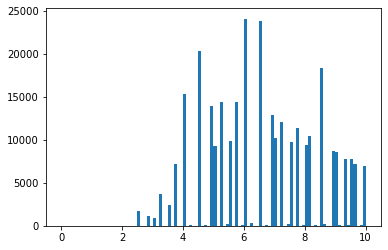

In [9]:
# fare_amount の棒グラフ 
plt.hist(df.fare_amount, bins=100, range=(0, 10))

In [10]:
# fare_amount がマイナスの行を削除
# df.drop(df.index[df.fare_amount <= 0], inplace=True)

# 初乗り料金は、2.5ドルなので fair_amount はそれ以上とする
df = df[(df['fare_amount'] >= 2.5)]
df.shape

(489361, 8)

In [11]:
# fare_amount の最小値が2.5ドルになっていることを確認
print(min(df.fare_amount))

2.5


## 2. 関数の定義

In [12]:
# ２地点間の距離
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):

    # Define earth radius (km)
    R_earth = 6371
    # Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians, [pickup_lat, pickup_lon, dropoff_lat, dropoff_lon])
    # Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    # Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [13]:
# pickup地点とdroppff地点から、経度・緯度の差と2地点間の距離をdfに追加
def add_coordinate_features(df):
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    # Add new features
    #df['latdiff'] = (lat1 - lat2)
    #df['londiff'] = (lon1 - lon2)
    df['distance'] = sphere_dist(lat1, lon1, lat2, lon2)

    return

In [14]:
# 空港からの距離をdfに追加
def add_airport_dist(df):
    
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    pickup_lat = df['pickup_latitude']
    dropoff_lat = df['dropoff_latitude']
    pickup_lon = df['pickup_longitude']
    dropoff_lon = df['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    df['jfk_dist'] = pickup_jfk + dropoff_jfk
    df['ewr_dist'] = pickup_ewr + dropoff_ewr
    df['lga_dist'] = pickup_lga + dropoff_lga
    df['sol_dist'] = pickup_sol + dropoff_sol
    df['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return

In [15]:
# 回帰結果評価用関数
def Regression_evaluator(y_test, y_pred):
    
    # 平均絶対誤差 (MAE: Mean Absolute Error)
    print("平均絶対誤差：", mean_absolute_error(y_test, y_pred))
    # 平均二乗誤差 (MSE: Mean Squared Error)
    print("平均絶対誤差：", mean_squared_error(y_test, y_pred))
    # 二乗平均平方根誤差 (RMSE: Root Mean Squared Error) -- sklearn には実装されていないのでnumpyを利用
    print("二乗平均平方根誤差：", np.sqrt(mean_squared_error(y_test, y_pred)))
    # 相関係数（Correlation)
    print("相関係数 (R)：", np.sqrt(r2_score(y_test, y_pred)))
    # 決定係数 (R2, R-squared, coefficient of determination)) 
    print("決定係数 (R2)：", r2_score(y_test, y_pred))
    
    return

In [16]:
# 散布図描画関数
def Draw_scatter(y_test, y_pred):
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_pred, s=0.5)
    plt.scatter(y_test, y_test, s=0.5)
    #plt.title('Linear regression')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.grid()
    plt.show()
    
    return

In [17]:
# 散布図描画関数(2)
def Draw_scatter2(y_test, y_pred):
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, y_pred, s=0.5)
    plt.scatter(y_test, y_test, s=0.5)
    plt.xlim(-10, 100)
    plt.ylim(-10, 100)
    #plt.title('Linear regression')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.grid()
    plt.show()
    
    return

## 3. 特徴量の作成 Feature Engineering

In [18]:
# pickup地点とdroppff地点間の距離をdfに追加
add_coordinate_features(df)

In [19]:
# 空港からの距離をdfに追加
add_airport_dist(df)

In [20]:
# datetimeを分離するしてdfに追加 --> 時間がかかる

print("------------ pd.to_datetime --------------", flush=True)
start = time.time() # 計算前の時間取得
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
calc_time = time.time() - start # 計算時間
print("pd.to_datetime: {:.2f}sec".format(calc_time), flush=True)

df['pickup_datetime_month'] = df['pickup_datetime'].dt.month
df['pickup_datetime_year'] = df['pickup_datetime'].dt.year
df['pickup_datetime_day_of_week'] = df['pickup_datetime'].dt.weekday
df['pickup_datetime_day_of_hour'] = df['pickup_datetime'].dt.hour

------------ pd.to_datetime --------------
pd.to_datetime: 45.87sec


In [21]:
# 最短および最長距離
print("Minimum distance:", min(df.distance))
print("Maximum distance:", max(df.distance))

Minimum distance: 0.0
Maximum distance: 110.83307658560939


(array([0.00000e+00, 3.24370e+04, 1.07033e+05, 1.00471e+05, 7.26160e+04,
        5.61580e+04, 2.92410e+04, 2.02610e+04, 1.47930e+04, 9.38800e+03,
        7.37800e+03, 5.00200e+03, 4.26400e+03, 4.24900e+03, 3.47200e+03,
        3.13400e+03, 2.36500e+03, 1.98800e+03, 1.53900e+03, 1.06600e+03,
        9.00000e+02, 1.91800e+03, 4.46000e+02, 3.17000e+03, 1.28500e+03,
        2.70000e+02, 1.90000e+02, 2.94000e+03, 1.65000e+02, 1.23000e+02,
        1.52000e+02, 8.10000e+01, 8.20000e+01, 8.50000e+01, 5.90000e+01,
        5.60000e+01, 5.30000e+01, 6.30000e+01, 6.20000e+01, 3.40000e+01,
        4.90000e+01, 3.20000e+01, 2.80000e+01, 1.80000e+01, 1.70000e+01,
        1.40000e+01, 1.00000e+01, 2.30000e+01, 6.00000e+00, 1.20000e+01,
        1.30000e+01, 2.00000e+00, 1.20000e+01, 5.00000e+00, 5.00000e+00,
        5.00000e+00, 6.00000e+00, 1.30000e+01, 8.00000e+00, 3.00000e+00,
        6.00000e+00, 9.00000e+00, 4.00000e+00, 1.00000e+00, 5.00000e+00,
        2.00000e+00, 5.00000e+00, 0.00000e+00, 3.00

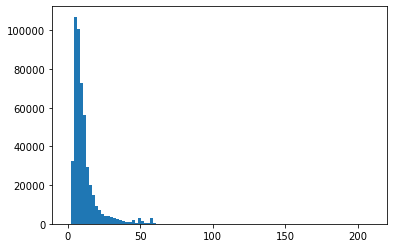

In [22]:
# distance の棒グラフ --> 全領域
plt.hist(df.fare_amount, bins=100, range=(0, 210))

In [23]:
# distance の棒グラフ --> 50-100km
plt.hist(df.fare_amount, bins=100, range=(50, 100))

(array([1.750e+02, 2.000e+02, 7.800e+01, 5.800e+01, 9.490e+02, 6.000e+01,
        7.100e+01, 4.700e+01, 5.400e+01, 6.600e+01, 6.000e+01, 4.100e+01,
        3.500e+01, 5.000e+02, 2.111e+03, 2.930e+02, 4.800e+01, 2.000e+01,
        2.900e+01, 3.800e+01, 6.800e+01, 2.500e+01, 3.100e+01, 3.700e+01,
        2.800e+01, 2.600e+01, 3.300e+01, 3.000e+01, 2.500e+01, 2.800e+01,
        5.000e+01, 1.800e+01, 2.200e+01, 1.400e+01, 2.700e+01, 1.800e+01,
        1.700e+01, 1.600e+01, 1.800e+01, 1.300e+01, 3.300e+01, 2.000e+01,
        1.900e+01, 1.500e+01, 1.200e+01, 1.300e+01, 1.800e+01, 1.200e+01,
        1.000e+01, 7.000e+00, 2.400e+01, 1.100e+01, 1.100e+01, 1.500e+01,
        1.300e+01, 1.000e+01, 1.600e+01, 1.600e+01, 1.500e+01, 1.300e+01,
        3.400e+01, 7.000e+00, 1.100e+01, 9.000e+00, 8.000e+00, 1.100e+01,
        8.000e+00, 7.000e+00, 9.000e+00, 8.000e+00, 1.800e+01, 7.000e+00,
        1.300e+01, 6.000e+00, 1.000e+01, 4.000e+00, 8.000e+00, 1.000e+00,
        8.000e+00, 4.000e+00, 1.300e+0

(array([12.,  2.,  4.,  5.,  7.,  8.,  5.,  1.,  1.,  7.,  5.,  1.,  3.,
         2.,  2.,  2.,  3.,  2.,  5.,  2., 11.,  1.,  3.,  5.,  0.,  3.,
         1.,  3.,  3.,  3.,  6.,  1.,  2.,  1.,  0.,  2.,  4.,  0.,  1.,
         2.,  3.,  0.,  0.,  1.,  2.,  3.,  1.,  0.,  0.,  2.,  4.,  1.,
         1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  4.,  2.,  0.,  0.,  1.,
         2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  4.]),
 array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
        111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
        122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
        133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
        155., 156., 157., 158., 159., 160., 161., 162., 163., 16

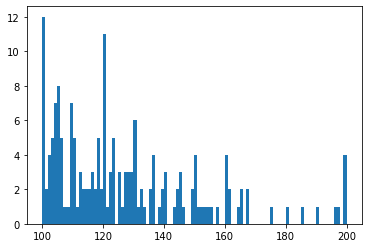

In [24]:
# distance の棒グラフ --> 100-200km
plt.hist(df.fare_amount, bins=100, range=(100, 200))

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.7070e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1280e+03, 0.0000e+00, 0.0000e+00,
        9.0100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7500e+03, 0.0000e+00, 1.7000e+01, 0.0000e+00, 0.0000e+00,
        2.4030e+03, 0.0000e+00, 0.0000e+00, 0.00

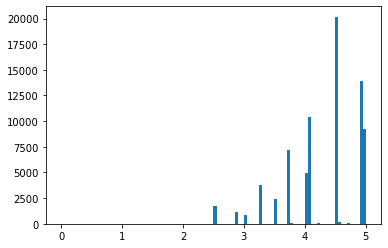

In [25]:
# distance の棒グラフ --> 近距離
plt.hist(df.fare_amount, bins=100, range=(0, 5))

In [26]:
# distance 下限を設定(100m)
df = df[(df.distance > 0.1)]

In [27]:
# 最短および最長距離
print("Minimum distance:", min(df.distance))
print("Maximum distance:", max(df.distance))

Minimum distance: 0.10001774926924407
Maximum distance: 110.83307658560939


In [28]:
df.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance   jfk_dist   ewr_dist   lga_dist   sol_dist  \
0                1  1.030764  20.265840  55.176046  14.342611  34.543548   
1                1  8.450134  44.667679  31.832358  23.130775  15.125872   
2                2  1.389525  43.597686  33.712082  19.865289  17.722624   
3                1  2.799270  42.642965  32.556289  21.063132  15.738963   
4                1  1.999157  43.329953  39.406828  15.219339  23.732406   

    nyc_dist  pickup_datetime_month  pickup_datetime_year  \
0  27.572573                      6                  2009   
1   8.755732                      1                  2010   
2   9.847344                      8                  2011   
3   7.703421                      4                  2012   
4  15.600745                      3                  2010   

   pickup_datetime_day_of_week  pickup_datetime_day_of_hour  
0                            0                           17  
1                            1                           16  
2                            3                            0  
3                            5                            4  
4                            1                            7

In [29]:
df.shape

(481206, 18)

In [30]:
# 特徴量設定後の df を保存
df.to_csv("./data/df_treated.csv",index=False)

In [31]:
# CSVファイルの読み込み
# df = pd.read_csv("./data/df_treated.csv")

## 4. 学習用・検証用データセット作成

In [31]:
# 説明変数と目的変数の分離
X = df.drop(["fare_amount","key","pickup_datetime"], axis=1)
y = df.fare_amount

In [32]:
# 説明変数（X)のデータ標準化
# Tree 系のアルゴリズムでは不要：https://amalog.hateblo.jp/entry/decision-tree-scaling
#X_col = X.columns
#X_std = StandardScaler().fit_transform(X)
#X_std = pd.DataFrame(X_std, index=df.index, columns=X_col)

In [33]:
# 学習用・検証用データセット作成
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## 5. 学習と検証

### 5-1. Random Forest

In [34]:
# Grid serch ようのデータセット作成
X_tmp, X_gs, y_tmp, y_gs = train_test_split(X_train, y_train, test_size=0.01, random_state=0) # 訓練用の 5%
X_gs.shape

(4331, 15)

In [35]:
# ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split, GridSearchCV

RFR(n_jobs=-1, random_state=2525)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=2525, verbose=0, warm_start=False)

In [36]:
# https://www.sejuku.net/blog/64374

search_params = {
    'n_estimators'      : [75, 100, 125],
    'max_features'      : [i for i in range(1,X_gs.shape[1])],
    'random_state'      : [2525],
    'n_jobs'            : [1],
    'min_samples_split' : [2, 3, 5],
    'max_depth'         : [15, 20, 25]
}
 
gsr = GridSearchCV(
    RFR(),
    search_params,
    cv = 3,
    n_jobs = -1,
    verbose=True
)

start = time.time() # 計算前の時間取得
 
gsr.fit(X_gs, y_gs)

gs_calc_time = time.time() - start # 計算時間

Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  4.1min finished


In [37]:
print("Calculating time: {:.2f}sec".format(gs_calc_time))

Calculating time: 248.42sec


In [38]:
# モデルの定義
model_rf = gsr.best_estimator_
model_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=1, oob_score=False,
                      random_state=2525, verbose=0, warm_start=False)

In [39]:
# モデルの学習
start = time.time() # 計算前の時間取得

model_rf.fit(X_train, y_train)

rf_calc_time = time.time() - start # 計算時間
print("Calculating time: {:.2f}sec".format(rf_calc_time))

Calculating time: 244.52sec


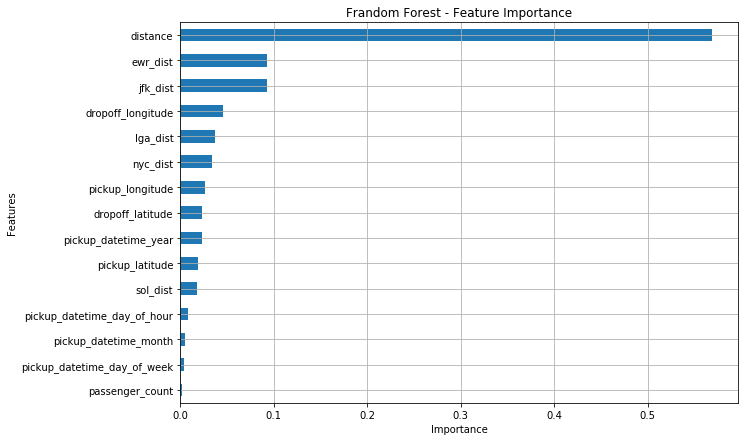

In [40]:
# 説明変数の重要度のグラフ化
fea_imp = pd.DataFrame({'imp': model_rf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Frandom Forest - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.grid()
plt.show()

In [41]:
# テストデータ（検証データ）で予測
y_pred = model_rf.predict(X_test)
rf_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

In [42]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.5638389574855927
平均絶対誤差： 13.243581040957059
二乗平均平方根誤差： 3.639173125994016
相関係数 (R)： 0.9249126331291815
決定係数 (R2)： 0.8554633789219558


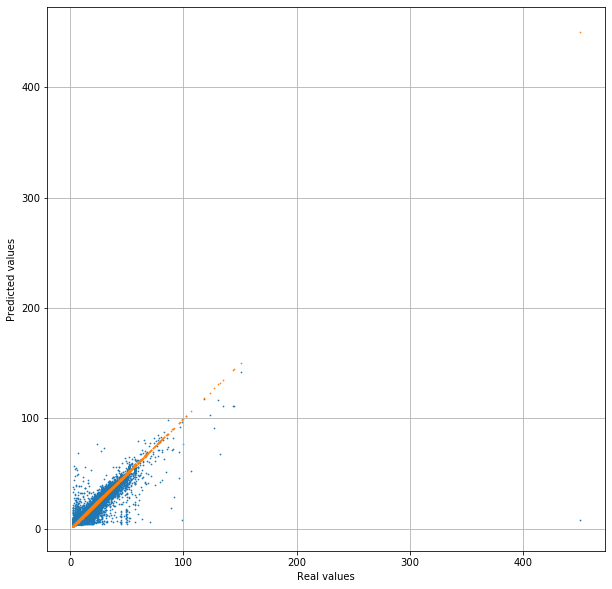

In [43]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

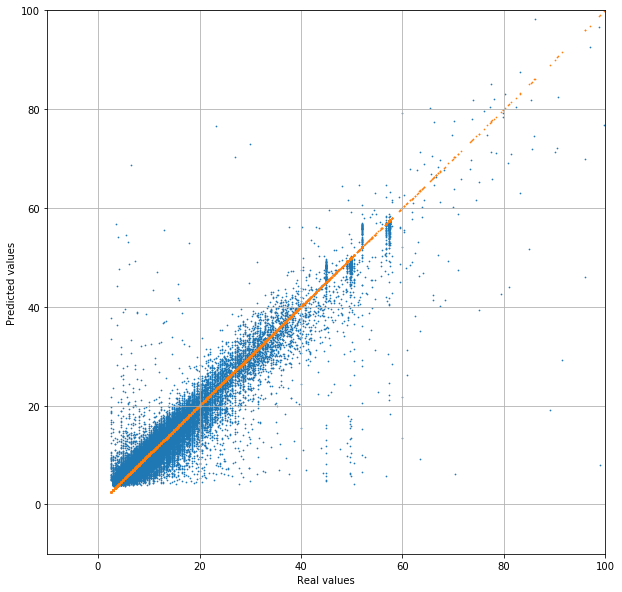

In [44]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

### 5-2. Catboost

In [45]:
# Catboost
# https://towardsdatascience.com/ad-demand-forecast-with-catboost-lightgbm-819e5073cd3e
# https://qiita.com/Mt_Taka/items/e12694aa5a7ed9539216

from catboost import CatBoostRegressor

gc.collect()

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

model_cat = CatBoostRegressor(iterations=10000, depth=10, loss_function='RMSE', early_stopping_rounds=100)

start = time.time() # 計算前の時間取得

model_cat.fit(train_pool, eval_set=test_pool, plot=True)

cat_calc_time = time.time() - start # 計算時間

gc.collect() # Garbage Collection

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.034578
0:	learn: 9.1847963	test: 9.3116308	best: 9.3116308 (0)	total: 143ms	remaining: 23m 47s
1:	learn: 8.9297457	test: 9.0628169	best: 9.0628169 (1)	total: 233ms	remaining: 19m 22s
2:	learn: 8.6845705	test: 8.8254089	best: 8.8254089 (2)	total: 319ms	remaining: 17m 42s
3:	learn: 8.4492272	test: 8.5967643	best: 8.5967643 (3)	total: 400ms	remaining: 16m 40s
4:	learn: 8.2219733	test: 8.3757730	best: 8.3757730 (4)	total: 482ms	remaining: 16m 4s
5:	learn: 8.0038213	test: 8.1640919	best: 8.1640919 (5)	total: 570ms	remaining: 15m 49s
6:	learn: 7.7949570	test: 7.9619349	best: 7.9619349 (6)	total: 653ms	remaining: 15m 31s
7:	learn: 7.5944082	test: 7.7682509	best: 7.7682509 (7)	total: 736ms	remaining: 15m 19s
8:	learn: 7.4028379	test: 7.5851293	best: 7.5851293 (8)	total: 824ms	remaining: 15m 14s
9:	learn: 7.2167914	test: 7.4058142	best: 7.4058142 (9)	total: 913ms	remaining: 15m 12s
10:	learn: 7.0380414	test: 7.2340773	best: 7.2340773 (10)	total: 1.01s	remaining: 15m 14s
1

92:	learn: 3.3780470	test: 3.8997951	best: 3.8997951 (92)	total: 7.99s	remaining: 14m 10s
93:	learn: 3.3732864	test: 3.8962680	best: 3.8962680 (93)	total: 8.08s	remaining: 14m 11s
94:	learn: 3.3683991	test: 3.8933748	best: 3.8933748 (94)	total: 8.16s	remaining: 14m 10s
95:	learn: 3.3640636	test: 3.8900278	best: 3.8900278 (95)	total: 8.24s	remaining: 14m 10s
96:	learn: 3.3598675	test: 3.8874479	best: 3.8874479 (96)	total: 8.34s	remaining: 14m 11s
97:	learn: 3.3560689	test: 3.8847016	best: 3.8847016 (97)	total: 8.42s	remaining: 14m 10s
98:	learn: 3.3514705	test: 3.8818405	best: 3.8818405 (98)	total: 8.5s	remaining: 14m 10s
99:	learn: 3.3468223	test: 3.8784091	best: 3.8784091 (99)	total: 8.58s	remaining: 14m 9s
100:	learn: 3.3432319	test: 3.8751823	best: 3.8751823 (100)	total: 8.66s	remaining: 14m 8s
101:	learn: 3.3395608	test: 3.8720978	best: 3.8720978 (101)	total: 8.74s	remaining: 14m 8s
102:	learn: 3.3360319	test: 3.8697223	best: 3.8697223 (102)	total: 8.84s	remaining: 14m 9s
103:	lear

183:	learn: 3.1557256	test: 3.7684344	best: 3.7684344 (183)	total: 16.1s	remaining: 14m 18s
184:	learn: 3.1542342	test: 3.7673616	best: 3.7673616 (184)	total: 16.2s	remaining: 14m 17s
185:	learn: 3.1524733	test: 3.7667014	best: 3.7667014 (185)	total: 16.3s	remaining: 14m 17s
186:	learn: 3.1513734	test: 3.7660015	best: 3.7660015 (186)	total: 16.4s	remaining: 14m 18s
187:	learn: 3.1502363	test: 3.7654492	best: 3.7654492 (187)	total: 16.5s	remaining: 14m 19s
188:	learn: 3.1489781	test: 3.7650591	best: 3.7650591 (188)	total: 16.6s	remaining: 14m 19s
189:	learn: 3.1473804	test: 3.7644628	best: 3.7644628 (189)	total: 16.7s	remaining: 14m 19s
190:	learn: 3.1460157	test: 3.7639005	best: 3.7639005 (190)	total: 16.7s	remaining: 14m 19s
191:	learn: 3.1443809	test: 3.7631490	best: 3.7631490 (191)	total: 16.8s	remaining: 14m 18s
192:	learn: 3.1425008	test: 3.7621993	best: 3.7621993 (192)	total: 16.9s	remaining: 14m 18s
193:	learn: 3.1406359	test: 3.7613796	best: 3.7613796 (193)	total: 17s	remaining

274:	learn: 3.0519155	test: 3.7180789	best: 3.7180789 (274)	total: 24.2s	remaining: 14m 16s
275:	learn: 3.0504841	test: 3.7171867	best: 3.7171867 (275)	total: 24.3s	remaining: 14m 16s
276:	learn: 3.0494087	test: 3.7166138	best: 3.7166138 (276)	total: 24.4s	remaining: 14m 16s
277:	learn: 3.0483677	test: 3.7158887	best: 3.7158887 (277)	total: 24.5s	remaining: 14m 16s
278:	learn: 3.0470814	test: 3.7151081	best: 3.7151081 (278)	total: 24.6s	remaining: 14m 16s
279:	learn: 3.0463833	test: 3.7149219	best: 3.7149219 (279)	total: 24.6s	remaining: 14m 15s
280:	learn: 3.0448637	test: 3.7139993	best: 3.7139993 (280)	total: 24.7s	remaining: 14m 15s
281:	learn: 3.0442777	test: 3.7136946	best: 3.7136946 (281)	total: 24.8s	remaining: 14m 15s
282:	learn: 3.0434856	test: 3.7133235	best: 3.7133235 (282)	total: 24.9s	remaining: 14m 14s
283:	learn: 3.0423368	test: 3.7129243	best: 3.7129243 (283)	total: 25s	remaining: 14m 14s
284:	learn: 3.0412489	test: 3.7121524	best: 3.7121524 (284)	total: 25.1s	remaining

364:	learn: 2.9758646	test: 3.6848931	best: 3.6848931 (364)	total: 32.1s	remaining: 14m 6s
365:	learn: 2.9751194	test: 3.6844860	best: 3.6844860 (365)	total: 32.2s	remaining: 14m 6s
366:	learn: 2.9743709	test: 3.6842567	best: 3.6842567 (366)	total: 32.2s	remaining: 14m 6s
367:	learn: 2.9736103	test: 3.6837566	best: 3.6837566 (367)	total: 32.3s	remaining: 14m 5s
368:	learn: 2.9727229	test: 3.6837201	best: 3.6837201 (368)	total: 32.4s	remaining: 14m 5s
369:	learn: 2.9719804	test: 3.6833532	best: 3.6833532 (369)	total: 32.5s	remaining: 14m 6s
370:	learn: 2.9713809	test: 3.6834660	best: 3.6833532 (369)	total: 32.6s	remaining: 14m 6s
371:	learn: 2.9707889	test: 3.6833750	best: 3.6833532 (369)	total: 32.7s	remaining: 14m 5s
372:	learn: 2.9701741	test: 3.6832355	best: 3.6832355 (372)	total: 32.8s	remaining: 14m 5s
373:	learn: 2.9696459	test: 3.6830708	best: 3.6830708 (373)	total: 32.8s	remaining: 14m 5s
374:	learn: 2.9692091	test: 3.6831680	best: 3.6830708 (373)	total: 32.9s	remaining: 14m 4s

455:	learn: 2.9163304	test: 3.6614566	best: 3.6614566 (455)	total: 40.5s	remaining: 14m 7s
456:	learn: 2.9156917	test: 3.6612185	best: 3.6612185 (456)	total: 40.6s	remaining: 14m 7s
457:	learn: 2.9151014	test: 3.6610516	best: 3.6610516 (457)	total: 40.7s	remaining: 14m 7s
458:	learn: 2.9145188	test: 3.6609088	best: 3.6609088 (458)	total: 40.8s	remaining: 14m 7s
459:	learn: 2.9139356	test: 3.6605958	best: 3.6605958 (459)	total: 40.8s	remaining: 14m 6s
460:	learn: 2.9132687	test: 3.6603862	best: 3.6603862 (460)	total: 40.9s	remaining: 14m 6s
461:	learn: 2.9125554	test: 3.6599621	best: 3.6599621 (461)	total: 41s	remaining: 14m 6s
462:	learn: 2.9118443	test: 3.6594661	best: 3.6594661 (462)	total: 41.1s	remaining: 14m 6s
463:	learn: 2.9112244	test: 3.6593568	best: 3.6593568 (463)	total: 41.2s	remaining: 14m 6s
464:	learn: 2.9105760	test: 3.6591884	best: 3.6591884 (464)	total: 41.3s	remaining: 14m 6s
465:	learn: 2.9098734	test: 3.6588495	best: 3.6588495 (465)	total: 41.3s	remaining: 14m 5s
4

546:	learn: 2.8654471	test: 3.6434486	best: 3.6434486 (546)	total: 48.2s	remaining: 13m 52s
547:	learn: 2.8650493	test: 3.6432778	best: 3.6432778 (547)	total: 48.3s	remaining: 13m 52s
548:	learn: 2.8646747	test: 3.6431740	best: 3.6431740 (548)	total: 48.4s	remaining: 13m 52s
549:	learn: 2.8644003	test: 3.6431580	best: 3.6431580 (549)	total: 48.4s	remaining: 13m 52s
550:	learn: 2.8639752	test: 3.6429713	best: 3.6429713 (550)	total: 48.5s	remaining: 13m 52s
551:	learn: 2.8634637	test: 3.6428855	best: 3.6428855 (551)	total: 48.6s	remaining: 13m 51s
552:	learn: 2.8630590	test: 3.6427832	best: 3.6427832 (552)	total: 48.7s	remaining: 13m 51s
553:	learn: 2.8626035	test: 3.6427329	best: 3.6427329 (553)	total: 48.8s	remaining: 13m 51s
554:	learn: 2.8621570	test: 3.6425868	best: 3.6425868 (554)	total: 48.8s	remaining: 13m 51s
555:	learn: 2.8618631	test: 3.6424771	best: 3.6424771 (555)	total: 48.9s	remaining: 13m 50s
556:	learn: 2.8612584	test: 3.6422648	best: 3.6422648 (556)	total: 49s	remaining

637:	learn: 2.8252477	test: 3.6301683	best: 3.6301683 (637)	total: 56.1s	remaining: 13m 43s
638:	learn: 2.8246923	test: 3.6299959	best: 3.6299959 (638)	total: 56.2s	remaining: 13m 43s
639:	learn: 2.8243405	test: 3.6299324	best: 3.6299324 (639)	total: 56.3s	remaining: 13m 43s
640:	learn: 2.8238201	test: 3.6299198	best: 3.6299198 (640)	total: 56.4s	remaining: 13m 43s
641:	learn: 2.8233863	test: 3.6298107	best: 3.6298107 (641)	total: 56.5s	remaining: 13m 43s
642:	learn: 2.8228673	test: 3.6297195	best: 3.6297195 (642)	total: 56.5s	remaining: 13m 42s
643:	learn: 2.8224849	test: 3.6297170	best: 3.6297170 (643)	total: 56.6s	remaining: 13m 42s
644:	learn: 2.8221029	test: 3.6297272	best: 3.6297170 (643)	total: 56.7s	remaining: 13m 42s
645:	learn: 2.8215921	test: 3.6296620	best: 3.6296620 (645)	total: 56.8s	remaining: 13m 42s
646:	learn: 2.8211475	test: 3.6295074	best: 3.6295074 (646)	total: 56.9s	remaining: 13m 42s
647:	learn: 2.8208357	test: 3.6294696	best: 3.6294696 (647)	total: 57s	remaining

729:	learn: 2.7898602	test: 3.6212186	best: 3.6211069 (728)	total: 1m 3s	remaining: 13m 29s
730:	learn: 2.7895354	test: 3.6211826	best: 3.6211069 (728)	total: 1m 3s	remaining: 13m 29s
731:	learn: 2.7892079	test: 3.6209895	best: 3.6209895 (731)	total: 1m 3s	remaining: 13m 29s
732:	learn: 2.7888428	test: 3.6210801	best: 3.6209895 (731)	total: 1m 4s	remaining: 13m 29s
733:	learn: 2.7883902	test: 3.6209776	best: 3.6209776 (733)	total: 1m 4s	remaining: 13m 29s
734:	learn: 2.7878085	test: 3.6209834	best: 3.6209776 (733)	total: 1m 4s	remaining: 13m 29s
735:	learn: 2.7873754	test: 3.6210106	best: 3.6209776 (733)	total: 1m 4s	remaining: 13m 29s
736:	learn: 2.7869813	test: 3.6208736	best: 3.6208736 (736)	total: 1m 4s	remaining: 13m 29s
737:	learn: 2.7866559	test: 3.6208592	best: 3.6208592 (737)	total: 1m 4s	remaining: 13m 29s
738:	learn: 2.7864446	test: 3.6207970	best: 3.6207970 (738)	total: 1m 4s	remaining: 13m 29s
739:	learn: 2.7859980	test: 3.6206544	best: 3.6206544 (739)	total: 1m 4s	remaini

818:	learn: 2.7592023	test: 3.6161238	best: 3.6160967 (817)	total: 1m 11s	remaining: 13m 23s
819:	learn: 2.7588067	test: 3.6159944	best: 3.6159944 (819)	total: 1m 11s	remaining: 13m 23s
820:	learn: 2.7584784	test: 3.6157696	best: 3.6157696 (820)	total: 1m 11s	remaining: 13m 23s
821:	learn: 2.7581250	test: 3.6156484	best: 3.6156484 (821)	total: 1m 11s	remaining: 13m 23s
822:	learn: 2.7577057	test: 3.6155362	best: 3.6155362 (822)	total: 1m 12s	remaining: 13m 22s
823:	learn: 2.7573953	test: 3.6154426	best: 3.6154426 (823)	total: 1m 12s	remaining: 13m 22s
824:	learn: 2.7570124	test: 3.6154284	best: 3.6154284 (824)	total: 1m 12s	remaining: 13m 22s
825:	learn: 2.7566796	test: 3.6153748	best: 3.6153748 (825)	total: 1m 12s	remaining: 13m 22s
826:	learn: 2.7563998	test: 3.6151099	best: 3.6151099 (826)	total: 1m 12s	remaining: 13m 22s
827:	learn: 2.7560497	test: 3.6151304	best: 3.6151099 (826)	total: 1m 12s	remaining: 13m 22s
828:	learn: 2.7557495	test: 3.6150617	best: 3.6150617 (828)	total: 1m 

907:	learn: 2.7317723	test: 3.6105284	best: 3.6104710 (903)	total: 1m 19s	remaining: 13m 13s
908:	learn: 2.7315769	test: 3.6104779	best: 3.6104710 (903)	total: 1m 19s	remaining: 13m 13s
909:	learn: 2.7311976	test: 3.6103627	best: 3.6103627 (909)	total: 1m 19s	remaining: 13m 13s
910:	learn: 2.7308644	test: 3.6102277	best: 3.6102277 (910)	total: 1m 19s	remaining: 13m 13s
911:	learn: 2.7306333	test: 3.6103053	best: 3.6102277 (910)	total: 1m 19s	remaining: 13m 13s
912:	learn: 2.7302432	test: 3.6102939	best: 3.6102277 (910)	total: 1m 19s	remaining: 13m 13s
913:	learn: 2.7300092	test: 3.6101994	best: 3.6101994 (913)	total: 1m 19s	remaining: 13m 13s
914:	learn: 2.7296629	test: 3.6101450	best: 3.6101450 (914)	total: 1m 19s	remaining: 13m 13s
915:	learn: 2.7293335	test: 3.6102653	best: 3.6101450 (914)	total: 1m 20s	remaining: 13m 13s
916:	learn: 2.7290804	test: 3.6101334	best: 3.6101334 (916)	total: 1m 20s	remaining: 13m 13s
917:	learn: 2.7289384	test: 3.6101125	best: 3.6101125 (917)	total: 1m 

996:	learn: 2.7069422	test: 3.6053852	best: 3.6053086 (995)	total: 1m 27s	remaining: 13m 7s
997:	learn: 2.7066412	test: 3.6053754	best: 3.6053086 (995)	total: 1m 27s	remaining: 13m 7s
998:	learn: 2.7062966	test: 3.6051958	best: 3.6051958 (998)	total: 1m 27s	remaining: 13m 6s
999:	learn: 2.7060366	test: 3.6051894	best: 3.6051894 (999)	total: 1m 27s	remaining: 13m 6s
1000:	learn: 2.7058870	test: 3.6051734	best: 3.6051734 (1000)	total: 1m 27s	remaining: 13m 6s
1001:	learn: 2.7057310	test: 3.6050912	best: 3.6050912 (1001)	total: 1m 27s	remaining: 13m 6s
1002:	learn: 2.7054927	test: 3.6049956	best: 3.6049956 (1002)	total: 1m 27s	remaining: 13m 6s
1003:	learn: 2.7052671	test: 3.6050314	best: 3.6049956 (1002)	total: 1m 27s	remaining: 13m 6s
1004:	learn: 2.7050576	test: 3.6050507	best: 3.6049956 (1002)	total: 1m 27s	remaining: 13m 6s
1005:	learn: 2.7048928	test: 3.6050123	best: 3.6049956 (1002)	total: 1m 27s	remaining: 13m 6s
1006:	learn: 2.7047248	test: 3.6050139	best: 3.6049956 (1002)	total:

1084:	learn: 2.6852751	test: 3.6015510	best: 3.6015051 (1083)	total: 1m 34s	remaining: 12m 56s
1085:	learn: 2.6849647	test: 3.6016395	best: 3.6015051 (1083)	total: 1m 34s	remaining: 12m 56s
1086:	learn: 2.6848070	test: 3.6015817	best: 3.6015051 (1083)	total: 1m 34s	remaining: 12m 56s
1087:	learn: 2.6845355	test: 3.6016175	best: 3.6015051 (1083)	total: 1m 34s	remaining: 12m 55s
1088:	learn: 2.6843695	test: 3.6015304	best: 3.6015051 (1083)	total: 1m 34s	remaining: 12m 55s
1089:	learn: 2.6840140	test: 3.6013826	best: 3.6013826 (1089)	total: 1m 34s	remaining: 12m 55s
1090:	learn: 2.6837763	test: 3.6013841	best: 3.6013826 (1089)	total: 1m 34s	remaining: 12m 55s
1091:	learn: 2.6834334	test: 3.6012367	best: 3.6012367 (1091)	total: 1m 35s	remaining: 12m 55s
1092:	learn: 2.6832047	test: 3.6011967	best: 3.6011967 (1092)	total: 1m 35s	remaining: 12m 55s
1093:	learn: 2.6828767	test: 3.6012369	best: 3.6011967 (1092)	total: 1m 35s	remaining: 12m 55s
1094:	learn: 2.6826266	test: 3.6011851	best: 3.601

1172:	learn: 2.6643490	test: 3.5983524	best: 3.5983395 (1171)	total: 1m 42s	remaining: 12m 49s
1173:	learn: 2.6641218	test: 3.5983693	best: 3.5983395 (1171)	total: 1m 42s	remaining: 12m 49s
1174:	learn: 2.6639251	test: 3.5984050	best: 3.5983395 (1171)	total: 1m 42s	remaining: 12m 49s
1175:	learn: 2.6636921	test: 3.5984238	best: 3.5983395 (1171)	total: 1m 42s	remaining: 12m 49s
1176:	learn: 2.6634454	test: 3.5983261	best: 3.5983261 (1176)	total: 1m 42s	remaining: 12m 49s
1177:	learn: 2.6631583	test: 3.5982803	best: 3.5982803 (1177)	total: 1m 42s	remaining: 12m 49s
1178:	learn: 2.6629306	test: 3.5981817	best: 3.5981817 (1178)	total: 1m 42s	remaining: 12m 49s
1179:	learn: 2.6627224	test: 3.5982051	best: 3.5981817 (1178)	total: 1m 42s	remaining: 12m 49s
1180:	learn: 2.6624139	test: 3.5981305	best: 3.5981305 (1180)	total: 1m 43s	remaining: 12m 49s
1181:	learn: 2.6622041	test: 3.5980662	best: 3.5980662 (1181)	total: 1m 43s	remaining: 12m 49s
1182:	learn: 2.6620618	test: 3.5980578	best: 3.598

1261:	learn: 2.6441704	test: 3.5946866	best: 3.5946866 (1261)	total: 1m 49s	remaining: 12m 40s
1262:	learn: 2.6439199	test: 3.5946131	best: 3.5946131 (1262)	total: 1m 49s	remaining: 12m 40s
1263:	learn: 2.6436458	test: 3.5945389	best: 3.5945389 (1263)	total: 1m 49s	remaining: 12m 40s
1264:	learn: 2.6434882	test: 3.5945085	best: 3.5945085 (1264)	total: 1m 50s	remaining: 12m 40s
1265:	learn: 2.6433214	test: 3.5945298	best: 3.5945085 (1264)	total: 1m 50s	remaining: 12m 40s
1266:	learn: 2.6430226	test: 3.5945118	best: 3.5945085 (1264)	total: 1m 50s	remaining: 12m 39s
1267:	learn: 2.6428559	test: 3.5944433	best: 3.5944433 (1267)	total: 1m 50s	remaining: 12m 39s
1268:	learn: 2.6427098	test: 3.5943949	best: 3.5943949 (1268)	total: 1m 50s	remaining: 12m 39s
1269:	learn: 2.6424744	test: 3.5943740	best: 3.5943740 (1269)	total: 1m 50s	remaining: 12m 39s
1270:	learn: 2.6421774	test: 3.5943775	best: 3.5943740 (1269)	total: 1m 50s	remaining: 12m 39s
1271:	learn: 2.6419505	test: 3.5943589	best: 3.594

1350:	learn: 2.6259338	test: 3.5922452	best: 3.5922116 (1349)	total: 1m 58s	remaining: 12m 36s
1351:	learn: 2.6256516	test: 3.5920215	best: 3.5920215 (1351)	total: 1m 58s	remaining: 12m 36s
1352:	learn: 2.6253902	test: 3.5919794	best: 3.5919794 (1352)	total: 1m 58s	remaining: 12m 36s
1353:	learn: 2.6250690	test: 3.5918314	best: 3.5918314 (1353)	total: 1m 58s	remaining: 12m 36s
1354:	learn: 2.6249026	test: 3.5918248	best: 3.5918248 (1354)	total: 1m 58s	remaining: 12m 36s
1355:	learn: 2.6245998	test: 3.5918474	best: 3.5918248 (1354)	total: 1m 58s	remaining: 12m 36s
1356:	learn: 2.6244035	test: 3.5918818	best: 3.5918248 (1354)	total: 1m 58s	remaining: 12m 36s
1357:	learn: 2.6241874	test: 3.5919439	best: 3.5918248 (1354)	total: 1m 58s	remaining: 12m 36s
1358:	learn: 2.6239947	test: 3.5919003	best: 3.5918248 (1354)	total: 1m 58s	remaining: 12m 36s
1359:	learn: 2.6238304	test: 3.5918920	best: 3.5918248 (1354)	total: 1m 59s	remaining: 12m 36s
1360:	learn: 2.6235748	test: 3.5918003	best: 3.591

1439:	learn: 2.6078116	test: 3.5898225	best: 3.5898225 (1439)	total: 2m 6s	remaining: 12m 29s
1440:	learn: 2.6076208	test: 3.5897737	best: 3.5897737 (1440)	total: 2m 6s	remaining: 12m 29s
1441:	learn: 2.6074592	test: 3.5897550	best: 3.5897550 (1441)	total: 2m 6s	remaining: 12m 29s
1442:	learn: 2.6072561	test: 3.5897108	best: 3.5897108 (1442)	total: 2m 6s	remaining: 12m 29s
1443:	learn: 2.6070887	test: 3.5896048	best: 3.5896048 (1443)	total: 2m 6s	remaining: 12m 29s
1444:	learn: 2.6069239	test: 3.5895753	best: 3.5895753 (1444)	total: 2m 6s	remaining: 12m 29s
1445:	learn: 2.6067155	test: 3.5895413	best: 3.5895413 (1445)	total: 2m 6s	remaining: 12m 29s
1446:	learn: 2.6065355	test: 3.5894771	best: 3.5894771 (1446)	total: 2m 6s	remaining: 12m 29s
1447:	learn: 2.6063403	test: 3.5894652	best: 3.5894652 (1447)	total: 2m 6s	remaining: 12m 28s
1448:	learn: 2.6061015	test: 3.5894194	best: 3.5894194 (1448)	total: 2m 6s	remaining: 12m 28s
1449:	learn: 2.6059358	test: 3.5893854	best: 3.5893854 (1449

1526:	learn: 2.5905502	test: 3.5869247	best: 3.5868491 (1524)	total: 2m 13s	remaining: 12m 21s
1527:	learn: 2.5903895	test: 3.5869228	best: 3.5868491 (1524)	total: 2m 13s	remaining: 12m 21s
1528:	learn: 2.5902132	test: 3.5869143	best: 3.5868491 (1524)	total: 2m 13s	remaining: 12m 21s
1529:	learn: 2.5900516	test: 3.5868570	best: 3.5868491 (1524)	total: 2m 13s	remaining: 12m 21s
1530:	learn: 2.5898160	test: 3.5868307	best: 3.5868307 (1530)	total: 2m 13s	remaining: 12m 21s
1531:	learn: 2.5895854	test: 3.5868131	best: 3.5868131 (1531)	total: 2m 14s	remaining: 12m 21s
1532:	learn: 2.5894209	test: 3.5868041	best: 3.5868041 (1532)	total: 2m 14s	remaining: 12m 20s
1533:	learn: 2.5893021	test: 3.5867788	best: 3.5867788 (1533)	total: 2m 14s	remaining: 12m 20s
1534:	learn: 2.5890074	test: 3.5867445	best: 3.5867445 (1534)	total: 2m 14s	remaining: 12m 20s
1535:	learn: 2.5887988	test: 3.5866430	best: 3.5866430 (1535)	total: 2m 14s	remaining: 12m 20s
1536:	learn: 2.5885707	test: 3.5865524	best: 3.586

1613:	learn: 2.5761947	test: 3.5848747	best: 3.5848747 (1613)	total: 2m 21s	remaining: 12m 14s
1614:	learn: 2.5761275	test: 3.5848571	best: 3.5848571 (1614)	total: 2m 21s	remaining: 12m 14s
1615:	learn: 2.5759307	test: 3.5848249	best: 3.5848249 (1615)	total: 2m 21s	remaining: 12m 14s
1616:	learn: 2.5757555	test: 3.5848090	best: 3.5848090 (1616)	total: 2m 21s	remaining: 12m 14s
1617:	learn: 2.5756046	test: 3.5847913	best: 3.5847913 (1617)	total: 2m 21s	remaining: 12m 14s
1618:	learn: 2.5754916	test: 3.5847972	best: 3.5847913 (1617)	total: 2m 21s	remaining: 12m 13s
1619:	learn: 2.5753053	test: 3.5847933	best: 3.5847913 (1617)	total: 2m 21s	remaining: 12m 13s
1620:	learn: 2.5750950	test: 3.5847457	best: 3.5847457 (1620)	total: 2m 21s	remaining: 12m 13s
1621:	learn: 2.5748357	test: 3.5846988	best: 3.5846988 (1621)	total: 2m 22s	remaining: 12m 13s
1622:	learn: 2.5746723	test: 3.5846634	best: 3.5846634 (1622)	total: 2m 22s	remaining: 12m 13s
1623:	learn: 2.5744552	test: 3.5846445	best: 3.584

1701:	learn: 2.5607453	test: 3.5836916	best: 3.5836650 (1700)	total: 2m 28s	remaining: 12m 6s
1702:	learn: 2.5606262	test: 3.5836832	best: 3.5836650 (1700)	total: 2m 29s	remaining: 12m 6s
1703:	learn: 2.5604680	test: 3.5836334	best: 3.5836334 (1703)	total: 2m 29s	remaining: 12m 6s
1704:	learn: 2.5602553	test: 3.5834507	best: 3.5834507 (1704)	total: 2m 29s	remaining: 12m 6s
1705:	learn: 2.5600391	test: 3.5832294	best: 3.5832294 (1705)	total: 2m 29s	remaining: 12m 6s
1706:	learn: 2.5599011	test: 3.5832172	best: 3.5832172 (1706)	total: 2m 29s	remaining: 12m 5s
1707:	learn: 2.5597541	test: 3.5832075	best: 3.5832075 (1707)	total: 2m 29s	remaining: 12m 5s
1708:	learn: 2.5596310	test: 3.5831815	best: 3.5831815 (1708)	total: 2m 29s	remaining: 12m 5s
1709:	learn: 2.5594967	test: 3.5831776	best: 3.5831776 (1709)	total: 2m 29s	remaining: 12m 5s
1710:	learn: 2.5593499	test: 3.5831798	best: 3.5831776 (1709)	total: 2m 29s	remaining: 12m 5s
1711:	learn: 2.5592655	test: 3.5831692	best: 3.5831692 (1711

1791:	learn: 2.5461602	test: 3.5818283	best: 3.5817404 (1787)	total: 2m 36s	remaining: 11m 56s
1792:	learn: 2.5459862	test: 3.5817950	best: 3.5817404 (1787)	total: 2m 36s	remaining: 11m 56s
1793:	learn: 2.5458188	test: 3.5818290	best: 3.5817404 (1787)	total: 2m 36s	remaining: 11m 56s
1794:	learn: 2.5457009	test: 3.5818014	best: 3.5817404 (1787)	total: 2m 36s	remaining: 11m 56s
1795:	learn: 2.5455909	test: 3.5817707	best: 3.5817404 (1787)	total: 2m 36s	remaining: 11m 56s
1796:	learn: 2.5454641	test: 3.5817726	best: 3.5817404 (1787)	total: 2m 36s	remaining: 11m 55s
1797:	learn: 2.5453074	test: 3.5817809	best: 3.5817404 (1787)	total: 2m 36s	remaining: 11m 55s
1798:	learn: 2.5452293	test: 3.5817832	best: 3.5817404 (1787)	total: 2m 37s	remaining: 11m 55s
1799:	learn: 2.5451414	test: 3.5817804	best: 3.5817404 (1787)	total: 2m 37s	remaining: 11m 55s
1800:	learn: 2.5450168	test: 3.5818311	best: 3.5817404 (1787)	total: 2m 37s	remaining: 11m 55s
1801:	learn: 2.5449003	test: 3.5818257	best: 3.581

1878:	learn: 2.5325496	test: 3.5795842	best: 3.5795706 (1877)	total: 2m 43s	remaining: 11m 48s
1879:	learn: 2.5324117	test: 3.5795655	best: 3.5795655 (1879)	total: 2m 43s	remaining: 11m 48s
1880:	learn: 2.5322129	test: 3.5795128	best: 3.5795128 (1880)	total: 2m 44s	remaining: 11m 48s
1881:	learn: 2.5321264	test: 3.5794863	best: 3.5794863 (1881)	total: 2m 44s	remaining: 11m 48s
1882:	learn: 2.5320387	test: 3.5795279	best: 3.5794863 (1881)	total: 2m 44s	remaining: 11m 47s
1883:	learn: 2.5318876	test: 3.5795083	best: 3.5794863 (1881)	total: 2m 44s	remaining: 11m 47s
1884:	learn: 2.5317012	test: 3.5794491	best: 3.5794491 (1884)	total: 2m 44s	remaining: 11m 47s
1885:	learn: 2.5315760	test: 3.5794073	best: 3.5794073 (1885)	total: 2m 44s	remaining: 11m 47s
1886:	learn: 2.5313921	test: 3.5794491	best: 3.5794073 (1885)	total: 2m 44s	remaining: 11m 47s
1887:	learn: 2.5312440	test: 3.5795025	best: 3.5794073 (1885)	total: 2m 44s	remaining: 11m 47s
1888:	learn: 2.5310922	test: 3.5795181	best: 3.579

1966:	learn: 2.5196508	test: 3.5781300	best: 3.5780953 (1964)	total: 2m 51s	remaining: 11m 39s
1967:	learn: 2.5195286	test: 3.5781457	best: 3.5780953 (1964)	total: 2m 51s	remaining: 11m 39s
1968:	learn: 2.5193865	test: 3.5781074	best: 3.5780953 (1964)	total: 2m 51s	remaining: 11m 39s
1969:	learn: 2.5192866	test: 3.5780835	best: 3.5780835 (1969)	total: 2m 51s	remaining: 11m 38s
1970:	learn: 2.5191511	test: 3.5781147	best: 3.5780835 (1969)	total: 2m 51s	remaining: 11m 38s
1971:	learn: 2.5189693	test: 3.5780824	best: 3.5780824 (1971)	total: 2m 51s	remaining: 11m 38s
1972:	learn: 2.5188391	test: 3.5780583	best: 3.5780583 (1972)	total: 2m 51s	remaining: 11m 38s
1973:	learn: 2.5186342	test: 3.5780973	best: 3.5780583 (1972)	total: 2m 51s	remaining: 11m 38s
1974:	learn: 2.5185144	test: 3.5781222	best: 3.5780583 (1972)	total: 2m 51s	remaining: 11m 38s
1975:	learn: 2.5183578	test: 3.5780953	best: 3.5780583 (1972)	total: 2m 51s	remaining: 11m 38s
1976:	learn: 2.5182725	test: 3.5780940	best: 3.578

2055:	learn: 2.5077205	test: 3.5775910	best: 3.5775543 (2053)	total: 2m 58s	remaining: 11m 30s
2056:	learn: 2.5075888	test: 3.5776095	best: 3.5775543 (2053)	total: 2m 58s	remaining: 11m 30s
2057:	learn: 2.5074841	test: 3.5776133	best: 3.5775543 (2053)	total: 2m 58s	remaining: 11m 30s
2058:	learn: 2.5073870	test: 3.5775951	best: 3.5775543 (2053)	total: 2m 59s	remaining: 11m 30s
2059:	learn: 2.5072132	test: 3.5775607	best: 3.5775543 (2053)	total: 2m 59s	remaining: 11m 30s
2060:	learn: 2.5070307	test: 3.5775618	best: 3.5775543 (2053)	total: 2m 59s	remaining: 11m 30s
2061:	learn: 2.5069783	test: 3.5775563	best: 3.5775543 (2053)	total: 2m 59s	remaining: 11m 30s
2062:	learn: 2.5069166	test: 3.5775870	best: 3.5775543 (2053)	total: 2m 59s	remaining: 11m 30s
2063:	learn: 2.5067142	test: 3.5775717	best: 3.5775543 (2053)	total: 2m 59s	remaining: 11m 30s
2064:	learn: 2.5065850	test: 3.5776240	best: 3.5775543 (2053)	total: 2m 59s	remaining: 11m 29s
2065:	learn: 2.5064482	test: 3.5775592	best: 3.577

2143:	learn: 2.4970236	test: 3.5767492	best: 3.5766411 (2130)	total: 3m 6s	remaining: 11m 23s
2144:	learn: 2.4968960	test: 3.5767555	best: 3.5766411 (2130)	total: 3m 6s	remaining: 11m 23s
2145:	learn: 2.4967836	test: 3.5767464	best: 3.5766411 (2130)	total: 3m 6s	remaining: 11m 23s
2146:	learn: 2.4966963	test: 3.5767792	best: 3.5766411 (2130)	total: 3m 6s	remaining: 11m 23s
2147:	learn: 2.4965371	test: 3.5767603	best: 3.5766411 (2130)	total: 3m 6s	remaining: 11m 23s
2148:	learn: 2.4963473	test: 3.5767175	best: 3.5766411 (2130)	total: 3m 7s	remaining: 11m 23s
2149:	learn: 2.4962488	test: 3.5767119	best: 3.5766411 (2130)	total: 3m 7s	remaining: 11m 23s
2150:	learn: 2.4960821	test: 3.5766348	best: 3.5766348 (2150)	total: 3m 7s	remaining: 11m 23s
2151:	learn: 2.4959384	test: 3.5765793	best: 3.5765793 (2151)	total: 3m 7s	remaining: 11m 23s
2152:	learn: 2.4958292	test: 3.5766284	best: 3.5765793 (2151)	total: 3m 7s	remaining: 11m 23s
2153:	learn: 2.4957464	test: 3.5766390	best: 3.5765793 (2151

2231:	learn: 2.4843038	test: 3.5749558	best: 3.5749558 (2231)	total: 3m 14s	remaining: 11m 17s
2232:	learn: 2.4841957	test: 3.5749696	best: 3.5749558 (2231)	total: 3m 14s	remaining: 11m 17s
2233:	learn: 2.4840245	test: 3.5749604	best: 3.5749558 (2231)	total: 3m 14s	remaining: 11m 17s
2234:	learn: 2.4837960	test: 3.5749686	best: 3.5749558 (2231)	total: 3m 14s	remaining: 11m 17s
2235:	learn: 2.4836523	test: 3.5749422	best: 3.5749422 (2235)	total: 3m 15s	remaining: 11m 17s
2236:	learn: 2.4834838	test: 3.5749470	best: 3.5749422 (2235)	total: 3m 15s	remaining: 11m 17s
2237:	learn: 2.4833557	test: 3.5749758	best: 3.5749422 (2235)	total: 3m 15s	remaining: 11m 17s
2238:	learn: 2.4832135	test: 3.5750168	best: 3.5749422 (2235)	total: 3m 15s	remaining: 11m 17s
2239:	learn: 2.4831086	test: 3.5750040	best: 3.5749422 (2235)	total: 3m 15s	remaining: 11m 17s
2240:	learn: 2.4828978	test: 3.5749704	best: 3.5749422 (2235)	total: 3m 15s	remaining: 11m 17s
2241:	learn: 2.4828463	test: 3.5749708	best: 3.574

2318:	learn: 2.4727859	test: 3.5740016	best: 3.5739932 (2312)	total: 3m 22s	remaining: 11m 11s
2319:	learn: 2.4726721	test: 3.5739900	best: 3.5739900 (2319)	total: 3m 22s	remaining: 11m 11s
2320:	learn: 2.4725607	test: 3.5739720	best: 3.5739720 (2320)	total: 3m 22s	remaining: 11m 10s
2321:	learn: 2.4724575	test: 3.5739639	best: 3.5739639 (2321)	total: 3m 22s	remaining: 11m 10s
2322:	learn: 2.4723331	test: 3.5739199	best: 3.5739199 (2322)	total: 3m 22s	remaining: 11m 10s
2323:	learn: 2.4721820	test: 3.5739243	best: 3.5739199 (2322)	total: 3m 23s	remaining: 11m 10s
2324:	learn: 2.4720010	test: 3.5739790	best: 3.5739199 (2322)	total: 3m 23s	remaining: 11m 10s
2325:	learn: 2.4718564	test: 3.5739285	best: 3.5739199 (2322)	total: 3m 23s	remaining: 11m 10s
2326:	learn: 2.4717466	test: 3.5739021	best: 3.5739021 (2326)	total: 3m 23s	remaining: 11m 10s
2327:	learn: 2.4716688	test: 3.5739531	best: 3.5739021 (2326)	total: 3m 23s	remaining: 11m 10s
2328:	learn: 2.4715701	test: 3.5739732	best: 3.573

2406:	learn: 2.4623033	test: 3.5735274	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2407:	learn: 2.4621936	test: 3.5735337	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2408:	learn: 2.4620873	test: 3.5735346	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2409:	learn: 2.4619736	test: 3.5735416	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2410:	learn: 2.4617568	test: 3.5735423	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2411:	learn: 2.4616398	test: 3.5735578	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2412:	learn: 2.4615233	test: 3.5735996	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2413:	learn: 2.4614652	test: 3.5736394	best: 3.5733692 (2397)	total: 3m 30s	remaining: 11m 3s
2414:	learn: 2.4612550	test: 3.5736366	best: 3.5733692 (2397)	total: 3m 31s	remaining: 11m 2s
2415:	learn: 2.4611288	test: 3.5736500	best: 3.5733692 (2397)	total: 3m 31s	remaining: 11m 2s
2416:	learn: 2.4611010	test: 3.5736329	best: 3.5733692 (2397

2493:	learn: 2.4519449	test: 3.5733307	best: 3.5733307 (2493)	total: 3m 37s	remaining: 10m 55s
2494:	learn: 2.4517853	test: 3.5733284	best: 3.5733284 (2494)	total: 3m 37s	remaining: 10m 55s
2495:	learn: 2.4517230	test: 3.5733676	best: 3.5733284 (2494)	total: 3m 37s	remaining: 10m 55s
2496:	learn: 2.4514848	test: 3.5733663	best: 3.5733284 (2494)	total: 3m 38s	remaining: 10m 55s
2497:	learn: 2.4513735	test: 3.5733468	best: 3.5733284 (2494)	total: 3m 38s	remaining: 10m 54s
2498:	learn: 2.4512054	test: 3.5733788	best: 3.5733284 (2494)	total: 3m 38s	remaining: 10m 55s
2499:	learn: 2.4511223	test: 3.5733649	best: 3.5733284 (2494)	total: 3m 38s	remaining: 10m 54s
2500:	learn: 2.4510054	test: 3.5733192	best: 3.5733192 (2500)	total: 3m 38s	remaining: 10m 54s
2501:	learn: 2.4509162	test: 3.5732923	best: 3.5732923 (2501)	total: 3m 38s	remaining: 10m 54s
2502:	learn: 2.4508170	test: 3.5732939	best: 3.5732923 (2501)	total: 3m 38s	remaining: 10m 54s
2503:	learn: 2.4506803	test: 3.5732340	best: 3.573

2580:	learn: 2.4421803	test: 3.5724949	best: 3.5724782 (2561)	total: 3m 45s	remaining: 10m 47s
2581:	learn: 2.4421025	test: 3.5724755	best: 3.5724755 (2581)	total: 3m 45s	remaining: 10m 47s
2582:	learn: 2.4419990	test: 3.5725017	best: 3.5724755 (2581)	total: 3m 45s	remaining: 10m 47s
2583:	learn: 2.4418814	test: 3.5725098	best: 3.5724755 (2581)	total: 3m 45s	remaining: 10m 47s
2584:	learn: 2.4417290	test: 3.5725182	best: 3.5724755 (2581)	total: 3m 45s	remaining: 10m 47s
2585:	learn: 2.4416012	test: 3.5724720	best: 3.5724720 (2585)	total: 3m 45s	remaining: 10m 47s
2586:	learn: 2.4415158	test: 3.5724310	best: 3.5724310 (2586)	total: 3m 45s	remaining: 10m 47s
2587:	learn: 2.4414190	test: 3.5724692	best: 3.5724310 (2586)	total: 3m 45s	remaining: 10m 46s
2588:	learn: 2.4413186	test: 3.5724642	best: 3.5724310 (2586)	total: 3m 45s	remaining: 10m 46s
2589:	learn: 2.4410912	test: 3.5724133	best: 3.5724133 (2589)	total: 3m 46s	remaining: 10m 46s
2590:	learn: 2.4409905	test: 3.5724173	best: 3.572

2667:	learn: 2.4326293	test: 3.5719441	best: 3.5718939 (2609)	total: 3m 52s	remaining: 10m 39s
2668:	learn: 2.4324688	test: 3.5719289	best: 3.5718939 (2609)	total: 3m 52s	remaining: 10m 39s
2669:	learn: 2.4323323	test: 3.5718952	best: 3.5718939 (2609)	total: 3m 52s	remaining: 10m 39s
2670:	learn: 2.4322142	test: 3.5718858	best: 3.5718858 (2670)	total: 3m 52s	remaining: 10m 39s
2671:	learn: 2.4320493	test: 3.5718228	best: 3.5718228 (2671)	total: 3m 53s	remaining: 10m 39s
2672:	learn: 2.4319700	test: 3.5718425	best: 3.5718228 (2671)	total: 3m 53s	remaining: 10m 39s
2673:	learn: 2.4318578	test: 3.5718192	best: 3.5718192 (2673)	total: 3m 53s	remaining: 10m 38s
2674:	learn: 2.4317217	test: 3.5718130	best: 3.5718130 (2674)	total: 3m 53s	remaining: 10m 39s
2675:	learn: 2.4315980	test: 3.5718263	best: 3.5718130 (2674)	total: 3m 53s	remaining: 10m 39s
2676:	learn: 2.4314733	test: 3.5718564	best: 3.5718130 (2674)	total: 3m 53s	remaining: 10m 38s
2677:	learn: 2.4313661	test: 3.5718862	best: 3.571

2755:	learn: 2.4237600	test: 3.5716143	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2756:	learn: 2.4236609	test: 3.5716254	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2757:	learn: 2.4235513	test: 3.5716692	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2758:	learn: 2.4234625	test: 3.5716353	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2759:	learn: 2.4233349	test: 3.5716238	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2760:	learn: 2.4232052	test: 3.5716182	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2761:	learn: 2.4231120	test: 3.5716302	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2762:	learn: 2.4229913	test: 3.5716721	best: 3.5715887 (2745)	total: 4m	remaining: 10m 31s
2763:	learn: 2.4228471	test: 3.5716175	best: 3.5715887 (2745)	total: 4m 1s	remaining: 10m 30s
2764:	learn: 2.4227343	test: 3.5715809	best: 3.5715809 (2764)	total: 4m 1s	remaining: 10m 31s
2765:	learn: 2.4226100	test: 3.5716141	best: 3.5715809 (2764)	total: 4m 1s	remaining

2843:	learn: 2.4139926	test: 3.5713796	best: 3.5713358 (2830)	total: 4m 8s	remaining: 10m 24s
2844:	learn: 2.4139114	test: 3.5713444	best: 3.5713358 (2830)	total: 4m 8s	remaining: 10m 24s
2845:	learn: 2.4138058	test: 3.5713727	best: 3.5713358 (2830)	total: 4m 8s	remaining: 10m 24s
2846:	learn: 2.4137287	test: 3.5713515	best: 3.5713358 (2830)	total: 4m 8s	remaining: 10m 24s
2847:	learn: 2.4136360	test: 3.5713497	best: 3.5713358 (2830)	total: 4m 8s	remaining: 10m 24s
2848:	learn: 2.4135651	test: 3.5713509	best: 3.5713358 (2830)	total: 4m 8s	remaining: 10m 24s
2849:	learn: 2.4134567	test: 3.5712907	best: 3.5712907 (2849)	total: 4m 8s	remaining: 10m 23s
2850:	learn: 2.4133638	test: 3.5712836	best: 3.5712836 (2850)	total: 4m 8s	remaining: 10m 23s
2851:	learn: 2.4132606	test: 3.5712967	best: 3.5712836 (2850)	total: 4m 8s	remaining: 10m 23s
2852:	learn: 2.4131817	test: 3.5712952	best: 3.5712836 (2850)	total: 4m 8s	remaining: 10m 23s
2853:	learn: 2.4130689	test: 3.5712525	best: 3.5712525 (2853

2931:	learn: 2.4052905	test: 3.5712087	best: 3.5711467 (2861)	total: 4m 15s	remaining: 10m 16s
2932:	learn: 2.4052206	test: 3.5712238	best: 3.5711467 (2861)	total: 4m 15s	remaining: 10m 16s
2933:	learn: 2.4051507	test: 3.5711969	best: 3.5711467 (2861)	total: 4m 15s	remaining: 10m 16s
2934:	learn: 2.4050592	test: 3.5711729	best: 3.5711467 (2861)	total: 4m 16s	remaining: 10m 16s
2935:	learn: 2.4049393	test: 3.5711796	best: 3.5711467 (2861)	total: 4m 16s	remaining: 10m 16s
2936:	learn: 2.4047950	test: 3.5711434	best: 3.5711434 (2936)	total: 4m 16s	remaining: 10m 16s
2937:	learn: 2.4046907	test: 3.5711331	best: 3.5711331 (2937)	total: 4m 16s	remaining: 10m 16s
2938:	learn: 2.4046127	test: 3.5711211	best: 3.5711211 (2938)	total: 4m 16s	remaining: 10m 15s
2939:	learn: 2.4044887	test: 3.5711261	best: 3.5711211 (2938)	total: 4m 16s	remaining: 10m 15s
2940:	learn: 2.4043707	test: 3.5711361	best: 3.5711211 (2938)	total: 4m 16s	remaining: 10m 15s
2941:	learn: 2.4042836	test: 3.5711224	best: 3.571

3019:	learn: 2.3960711	test: 3.5709405	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3020:	learn: 2.3960237	test: 3.5709420	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3021:	learn: 2.3959574	test: 3.5709848	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3022:	learn: 2.3958739	test: 3.5710129	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3023:	learn: 2.3958089	test: 3.5709991	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3024:	learn: 2.3956841	test: 3.5709926	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3025:	learn: 2.3955785	test: 3.5709902	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3026:	learn: 2.3954815	test: 3.5709963	best: 3.5709079 (3004)	total: 4m 23s	remaining: 10m 8s
3027:	learn: 2.3954014	test: 3.5709525	best: 3.5709079 (3004)	total: 4m 24s	remaining: 10m 7s
3028:	learn: 2.3953223	test: 3.5709400	best: 3.5709079 (3004)	total: 4m 24s	remaining: 10m 7s
3029:	learn: 2.3952372	test: 3.5709415	best: 3.5709079 (3004

3109:	learn: 2.3875437	test: 3.5707496	best: 3.5705212 (3089)	total: 4m 31s	remaining: 10m
3110:	learn: 2.3874605	test: 3.5707665	best: 3.5705212 (3089)	total: 4m 31s	remaining: 10m
3111:	learn: 2.3873835	test: 3.5707643	best: 3.5705212 (3089)	total: 4m 31s	remaining: 10m
3112:	learn: 2.3873340	test: 3.5707657	best: 3.5705212 (3089)	total: 4m 31s	remaining: 10m
3113:	learn: 2.3872241	test: 3.5707072	best: 3.5705212 (3089)	total: 4m 31s	remaining: 10m
3114:	learn: 2.3870155	test: 3.5707363	best: 3.5705212 (3089)	total: 4m 31s	remaining: 10m
3115:	learn: 2.3869351	test: 3.5707448	best: 3.5705212 (3089)	total: 4m 31s	remaining: 9m 59s
3116:	learn: 2.3868701	test: 3.5707228	best: 3.5705212 (3089)	total: 4m 31s	remaining: 9m 59s
3117:	learn: 2.3867526	test: 3.5707552	best: 3.5705212 (3089)	total: 4m 31s	remaining: 9m 59s
3118:	learn: 2.3866671	test: 3.5707355	best: 3.5705212 (3089)	total: 4m 31s	remaining: 9m 59s
3119:	learn: 2.3865221	test: 3.5707007	best: 3.5705212 (3089)	total: 4m 31s	re

3197:	learn: 2.3790514	test: 3.5701504	best: 3.5701504 (3197)	total: 4m 38s	remaining: 9m 52s
3198:	learn: 2.3789705	test: 3.5701436	best: 3.5701436 (3198)	total: 4m 38s	remaining: 9m 52s
3199:	learn: 2.3788694	test: 3.5701673	best: 3.5701436 (3198)	total: 4m 38s	remaining: 9m 52s
3200:	learn: 2.3787463	test: 3.5701271	best: 3.5701271 (3200)	total: 4m 38s	remaining: 9m 52s
3201:	learn: 2.3787108	test: 3.5701251	best: 3.5701251 (3201)	total: 4m 38s	remaining: 9m 52s
3202:	learn: 2.3786335	test: 3.5701329	best: 3.5701251 (3201)	total: 4m 38s	remaining: 9m 51s
3203:	learn: 2.3785621	test: 3.5701489	best: 3.5701251 (3201)	total: 4m 39s	remaining: 9m 51s
3204:	learn: 2.3784477	test: 3.5700915	best: 3.5700915 (3204)	total: 4m 39s	remaining: 9m 51s
3205:	learn: 2.3783966	test: 3.5700908	best: 3.5700908 (3205)	total: 4m 39s	remaining: 9m 51s
3206:	learn: 2.3783053	test: 3.5701114	best: 3.5700908 (3205)	total: 4m 39s	remaining: 9m 51s
3207:	learn: 2.3782258	test: 3.5701149	best: 3.5700908 (3205

3287:	learn: 2.3705054	test: 3.5697260	best: 3.5697260 (3287)	total: 4m 46s	remaining: 9m 44s
3288:	learn: 2.3703672	test: 3.5697176	best: 3.5697176 (3288)	total: 4m 46s	remaining: 9m 44s
3289:	learn: 2.3702195	test: 3.5697083	best: 3.5697083 (3289)	total: 4m 46s	remaining: 9m 44s
3290:	learn: 2.3700874	test: 3.5696935	best: 3.5696935 (3290)	total: 4m 46s	remaining: 9m 44s
3291:	learn: 2.3699542	test: 3.5696808	best: 3.5696808 (3291)	total: 4m 46s	remaining: 9m 43s
3292:	learn: 2.3698788	test: 3.5696588	best: 3.5696588 (3292)	total: 4m 46s	remaining: 9m 43s
3293:	learn: 2.3698489	test: 3.5696671	best: 3.5696588 (3292)	total: 4m 46s	remaining: 9m 43s
3294:	learn: 2.3697445	test: 3.5696400	best: 3.5696400 (3294)	total: 4m 46s	remaining: 9m 43s
3295:	learn: 2.3696458	test: 3.5695950	best: 3.5695950 (3295)	total: 4m 46s	remaining: 9m 43s
3296:	learn: 2.3695530	test: 3.5696053	best: 3.5695950 (3295)	total: 4m 46s	remaining: 9m 43s
3297:	learn: 2.3694753	test: 3.5695926	best: 3.5695926 (3297

3376:	learn: 2.3615626	test: 3.5697465	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3377:	learn: 2.3614984	test: 3.5697438	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3378:	learn: 2.3613575	test: 3.5697235	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3379:	learn: 2.3612621	test: 3.5696900	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3380:	learn: 2.3611213	test: 3.5696419	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3381:	learn: 2.3610147	test: 3.5696607	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3382:	learn: 2.3609027	test: 3.5696184	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3383:	learn: 2.3608179	test: 3.5696057	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3384:	learn: 2.3607634	test: 3.5696174	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3385:	learn: 2.3606754	test: 3.5696049	best: 3.5695554 (3311)	total: 4m 54s	remaining: 9m 36s
3386:	learn: 2.3605398	test: 3.5695528	best: 3.5695528 (3386

3466:	learn: 2.3538360	test: 3.5693407	best: 3.5693379 (3446)	total: 5m 1s	remaining: 9m 28s
3467:	learn: 2.3537670	test: 3.5693612	best: 3.5693379 (3446)	total: 5m 1s	remaining: 9m 28s
3468:	learn: 2.3536177	test: 3.5693636	best: 3.5693379 (3446)	total: 5m 2s	remaining: 9m 28s
3469:	learn: 2.3535267	test: 3.5693479	best: 3.5693379 (3446)	total: 5m 2s	remaining: 9m 28s
3470:	learn: 2.3533701	test: 3.5693357	best: 3.5693357 (3470)	total: 5m 2s	remaining: 9m 28s
3471:	learn: 2.3532700	test: 3.5692914	best: 3.5692914 (3471)	total: 5m 2s	remaining: 9m 28s
3472:	learn: 2.3532108	test: 3.5692850	best: 3.5692850 (3472)	total: 5m 2s	remaining: 9m 28s
3473:	learn: 2.3531196	test: 3.5693158	best: 3.5692850 (3472)	total: 5m 2s	remaining: 9m 28s
3474:	learn: 2.3530367	test: 3.5693005	best: 3.5692850 (3472)	total: 5m 2s	remaining: 9m 28s
3475:	learn: 2.3529431	test: 3.5693111	best: 3.5692850 (3472)	total: 5m 2s	remaining: 9m 28s
3476:	learn: 2.3527858	test: 3.5693094	best: 3.5692850 (3472)	total: 5

3555:	learn: 2.3453760	test: 3.5690298	best: 3.5690023 (3541)	total: 5m 9s	remaining: 9m 21s
3556:	learn: 2.3453045	test: 3.5690364	best: 3.5690023 (3541)	total: 5m 10s	remaining: 9m 21s
3557:	learn: 2.3452394	test: 3.5690231	best: 3.5690023 (3541)	total: 5m 10s	remaining: 9m 21s
3558:	learn: 2.3451724	test: 3.5690238	best: 3.5690023 (3541)	total: 5m 10s	remaining: 9m 21s
3559:	learn: 2.3450278	test: 3.5690371	best: 3.5690023 (3541)	total: 5m 10s	remaining: 9m 21s
3560:	learn: 2.3449489	test: 3.5690415	best: 3.5690023 (3541)	total: 5m 10s	remaining: 9m 21s
3561:	learn: 2.3448296	test: 3.5690069	best: 3.5690023 (3541)	total: 5m 10s	remaining: 9m 21s
3562:	learn: 2.3447082	test: 3.5689854	best: 3.5689854 (3562)	total: 5m 10s	remaining: 9m 20s
3563:	learn: 2.3445865	test: 3.5689962	best: 3.5689854 (3562)	total: 5m 10s	remaining: 9m 20s
3564:	learn: 2.3445124	test: 3.5689889	best: 3.5689854 (3562)	total: 5m 10s	remaining: 9m 20s
3565:	learn: 2.3443893	test: 3.5690218	best: 3.5689854 (3562)

3644:	learn: 2.3377812	test: 3.5689685	best: 3.5688141 (3623)	total: 5m 17s	remaining: 9m 14s
3645:	learn: 2.3377114	test: 3.5689534	best: 3.5688141 (3623)	total: 5m 17s	remaining: 9m 14s
3646:	learn: 2.3376007	test: 3.5689654	best: 3.5688141 (3623)	total: 5m 17s	remaining: 9m 13s
3647:	learn: 2.3375174	test: 3.5689598	best: 3.5688141 (3623)	total: 5m 18s	remaining: 9m 13s
3648:	learn: 2.3374619	test: 3.5689771	best: 3.5688141 (3623)	total: 5m 18s	remaining: 9m 13s
3649:	learn: 2.3373429	test: 3.5689837	best: 3.5688141 (3623)	total: 5m 18s	remaining: 9m 13s
3650:	learn: 2.3372621	test: 3.5690057	best: 3.5688141 (3623)	total: 5m 18s	remaining: 9m 13s
3651:	learn: 2.3371987	test: 3.5689949	best: 3.5688141 (3623)	total: 5m 18s	remaining: 9m 13s
3652:	learn: 2.3371077	test: 3.5689927	best: 3.5688141 (3623)	total: 5m 18s	remaining: 9m 13s
3653:	learn: 2.3370504	test: 3.5689795	best: 3.5688141 (3623)	total: 5m 18s	remaining: 9m 13s
3654:	learn: 2.3369750	test: 3.5690071	best: 3.5688141 (3623

0

In [46]:
print("Calculating time: {:.2f}sec".format(cat_calc_time))

Calculating time: 336.46sec


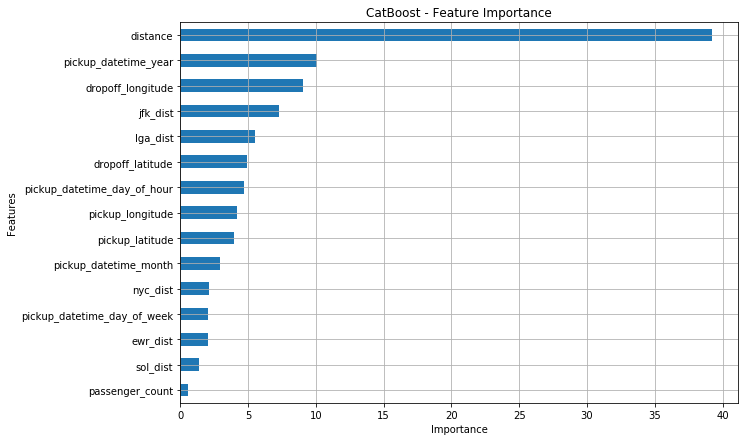

In [47]:
# 説明変数の重要度のグラフ化
fea_imp = pd.DataFrame({'imp': model_cat.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.grid()
plt.show()

In [48]:
y_pred = model_cat.predict(test_pool)
cat_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

In [49]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.4604291152728233
平均絶対誤差： 12.73643416917884
二乗平均平方根誤差： 3.568814112443914
相関係数 (R)： 0.927899904896136
決定係数 (R2)： 0.8609982335062583


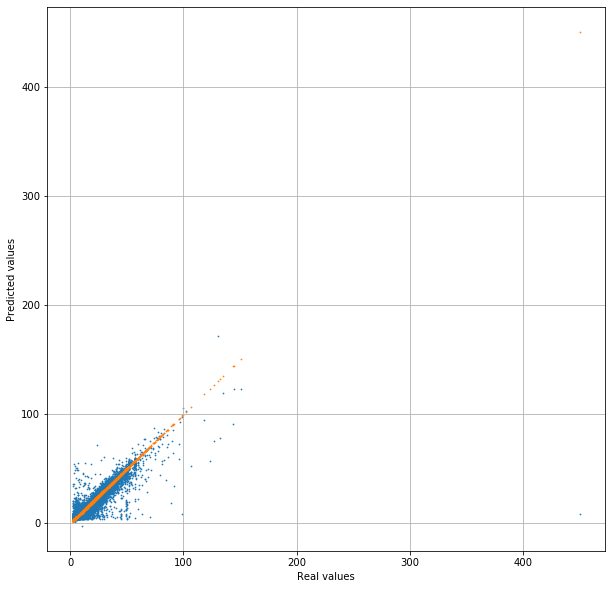

In [50]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

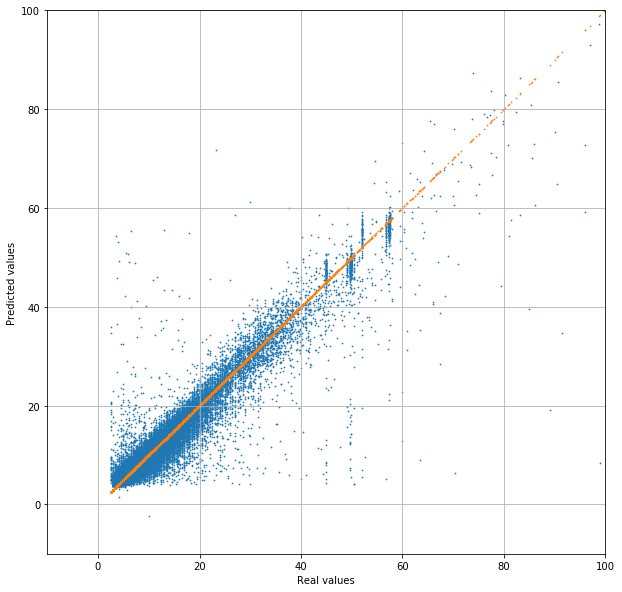

In [51]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

### 5-3. LightBGM

In [52]:
lgb.LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
# https://www.kaggle.com/namakaho/nyctaxi
# https://www.kaggle.com/jsylas/top-ten-rank-r-22m-rows-2-90-lightgbm

params = {'boosting_type':'gbdt',
          'objective': 'regression',
          'nthread': 4,
          'num_leaves': 31,
          'learning_rate': 0.034,
          'max_depth': -1,
          'subsample': 0.8,
          'bagging_fraction' : 1,
          'max_bin' : 5000 ,
          'bagging_freq': 20,
          'colsample_bytree': 0.6,
          'metric': 'rmse',      # rmse: root meam square error
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight':1,
          'zero_as_missing': True,
          'seed':128, # 0 から変更
          'num_rounds':10000}

In [54]:
train_set = lgb.Dataset(X_train, y_train, silent=False)
valid_set = lgb.Dataset(X_test, y_test, silent=False)

start = time.time() # 計算前の時間取得

model_lgb = lgb.train(params, train_set = train_set, num_boost_round=10,early_stopping_rounds=100,
                   verbose_eval=10, valid_sets=valid_set)

lgb_calc_time = time.time() - start # 計算時間

gc.collect() #Garbage Collection 

C:\Users\iiats\Anaconda3\envs\Python 3_7-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 7.70651
[20]	valid_0's rmse: 6.39047
[30]	valid_0's rmse: 5.49087
[40]	valid_0's rmse: 4.85971
[50]	valid_0's rmse: 4.46727
[60]	valid_0's rmse: 4.2322
[70]	valid_0's rmse: 4.08635
[80]	valid_0's rmse: 3.99489
[90]	valid_0's rmse: 3.93593
[100]	valid_0's rmse: 3.89082
[110]	valid_0's rmse: 3.85841
[120]	valid_0's rmse: 3.83437
[130]	valid_0's rmse: 3.81525
[140]	valid_0's rmse: 3.8016
[150]	valid_0's rmse: 3.78709
[160]	valid_0's rmse: 3.77507
[170]	valid_0's rmse: 3.76411
[180]	valid_0's rmse: 3.75745
[190]	valid_0's rmse: 3.74985
[200]	valid_0's rmse: 3.7443
[210]	valid_0's rmse: 3.73884
[220]	valid_0's rmse: 3.73288
[230]	valid_0's rmse: 3.72906
[240]	valid_0's rmse: 3.72559
[250]	valid_0's rmse: 3.72218
[260]	valid_0's rmse: 3.71756
[270]	valid_0's rmse: 3.71378
[280]	valid_0's rmse: 3.71098
[290]	valid_0's rmse: 3.70844
[300]	valid_0's rmse: 3.7051
[310]	valid_0's rmse: 3.70219
[320]	valid_0's rmse:

[2680]	valid_0's rmse: 3.58659
[2690]	valid_0's rmse: 3.58639
[2700]	valid_0's rmse: 3.58639
[2710]	valid_0's rmse: 3.58638
[2720]	valid_0's rmse: 3.58645
[2730]	valid_0's rmse: 3.58632
[2740]	valid_0's rmse: 3.58632
[2750]	valid_0's rmse: 3.58635
[2760]	valid_0's rmse: 3.58653
[2770]	valid_0's rmse: 3.58644
[2780]	valid_0's rmse: 3.58642
[2790]	valid_0's rmse: 3.58636
[2800]	valid_0's rmse: 3.58645
[2810]	valid_0's rmse: 3.58647
[2820]	valid_0's rmse: 3.58633
[2830]	valid_0's rmse: 3.58615
[2840]	valid_0's rmse: 3.58608
[2850]	valid_0's rmse: 3.58588
[2860]	valid_0's rmse: 3.58571
[2870]	valid_0's rmse: 3.58552
[2880]	valid_0's rmse: 3.58554
[2890]	valid_0's rmse: 3.58557
[2900]	valid_0's rmse: 3.58562
[2910]	valid_0's rmse: 3.58557
[2920]	valid_0's rmse: 3.58574
[2930]	valid_0's rmse: 3.58568
[2940]	valid_0's rmse: 3.58547
[2950]	valid_0's rmse: 3.5855
[2960]	valid_0's rmse: 3.5854
[2970]	valid_0's rmse: 3.58548
[2980]	valid_0's rmse: 3.58541
[2990]	valid_0's rmse: 3.58554
[3000]	val

8918

In [55]:
print("Calculating time: {:.2f}sec".format(lgb_calc_time))

Calculating time: 105.63sec


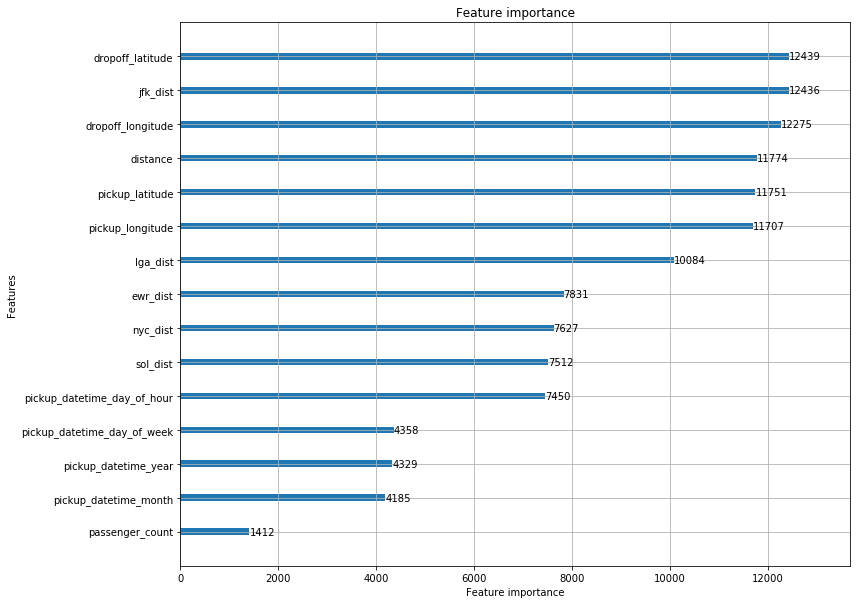

In [56]:
lgb.plot_importance(model_lgb, figsize=(12, 10))

In [57]:
y_pred = model_lgb.predict(X_test)
lgb_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

In [58]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.4840443453643004
平均絶対誤差： 12.798539913534691
二乗平均平方根誤差： 3.577504704893439
相関係数 (R)： 0.9275345973803397
決定係数 (R2)： 0.8603204293375089


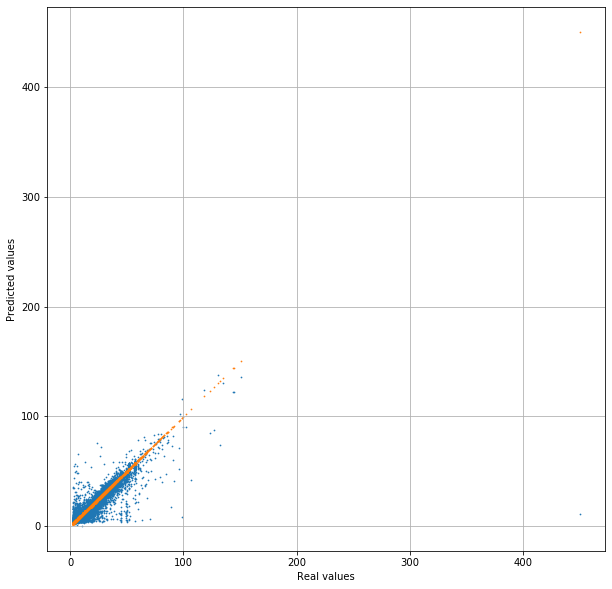

In [59]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

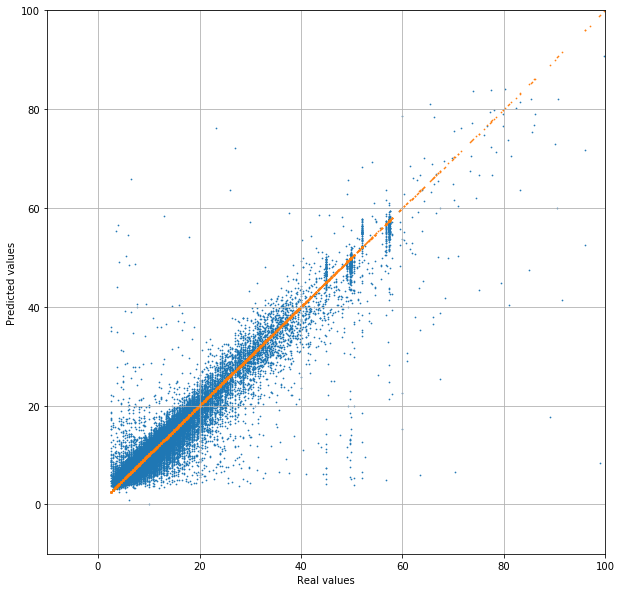

In [60]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

### 5-4. XGBoost

In [61]:
# XGBoost
# https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares

# Cross-validation
params = {
    # Parameters that we are going to tune.
    'max_depth': 8, # Result of tuning with CV
    'eta':.03, # Result of tuning with CV
    'subsample': 1, # Result of tuning with CV
    'colsample_bytree': 0.8, # Result of tuning with CV
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1}

# Block of code used for hypertuning parameters. Adapt to each round of parameter tuning.
# Turn off CV in submission
CV=False
if CV:
    dtrain = xgb.DMatrix(train,label=y)
    gridsearch_params = [
        (eta)
        for eta in np.arange(.04, 0.12, .02)
    ]

    # Define initial best params and RMSE
    min_rmse = float("Inf")
    best_params = None
    for (eta) in gridsearch_params:
        print("CV with eta={} ".format(eta))

        # Update our parameters
        params['eta'] = eta

        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=3,
            metrics={'rmse'},
            early_stopping_rounds=100
        )

        # Update best RMSE
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].argmin()
        print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = (eta)

    print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
else:
    # Print final params to use for the model
    params['silent'] = 0 # Turn on output
    print(params)

{'max_depth': 8, 'eta': 0.03, 'subsample': 1, 'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': 0}


In [62]:
def XGBmodel(X_train, X_test, y_train, y_test, params):
    matrix_train = xgb.DMatrix(X_train, label=y_train)
    matrix_test = xgb.DMatrix(X_test, label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train, num_boost_round=10000, 
                    early_stopping_rounds=10, evals=[(matrix_test,'test')])
    return model

start = time.time() # 計算前の時間取得

model_xgb = XGBmodel(X_train, X_test, y_train, y_test,params) # Takes long time

xgb_calc_time = time.time() - start # 計算時間

gc.collect() #Garbage Collection 

[23:02:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:14.025
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:13.6618
[2]	test-rmse:13.2907
[3]	test-rmse:12.9279
[4]	test-rmse:12.5815
[5]	test-rmse:12.2648
[6]	test-rmse:11.9592
[7]	test-rmse:11.6404
[8]	test-rmse:11.335
[9]	test-rmse:11.0368
[10]	test-rmse:10.7487
[11]	test-rmse:10.4701
[12]	test-rmse:10.2174
[13]	test-rmse:9.95736
[14]	test-rmse:9.70578
[15]	test-rmse:9.46358
[16]	test-rmse:9.23137
[17]	test-rmse:9.00482
[18]	test-rmse:8.78673
[19]	test-rmse:8.57642
[20]	test-rmse:8.37397
[21]	test-rmse:8.19123
[22]	test-rmse:8.00365
[23]	test-rmse:7.83354
[24]	test-rmse:7.65782
[25]	test-rmse:7.48803
[26]	test-rmse:7.32516
[27]	test-rmse:7.16702
[28]	test-rmse:7.02561
[29]	test-rmse:6.88957
[30]	test-rmse:6.74789
[31]	test-rmse:6.62013
[32]	test-rmse:6.48993
[33]	test-rmse:6.36596
[34]	test-rmse:6.24561
[35]	test-rmse:6.13881
[36]	test-r

[341]	test-rmse:3.64124
[342]	test-rmse:3.64089
[343]	test-rmse:3.64071
[344]	test-rmse:3.64036
[345]	test-rmse:3.63999
[346]	test-rmse:3.63977
[347]	test-rmse:3.63964
[348]	test-rmse:3.63959
[349]	test-rmse:3.63962
[350]	test-rmse:3.6394
[351]	test-rmse:3.6394
[352]	test-rmse:3.63911
[353]	test-rmse:3.63918
[354]	test-rmse:3.63898
[355]	test-rmse:3.63877
[356]	test-rmse:3.63856
[357]	test-rmse:3.63846
[358]	test-rmse:3.63853
[359]	test-rmse:3.63777
[360]	test-rmse:3.63749
[361]	test-rmse:3.63728
[362]	test-rmse:3.6374
[363]	test-rmse:3.63718
[364]	test-rmse:3.63709
[365]	test-rmse:3.63714
[366]	test-rmse:3.637
[367]	test-rmse:3.63663
[368]	test-rmse:3.63643
[369]	test-rmse:3.63604
[370]	test-rmse:3.63569
[371]	test-rmse:3.6354
[372]	test-rmse:3.63535
[373]	test-rmse:3.63521
[374]	test-rmse:3.635
[375]	test-rmse:3.63474
[376]	test-rmse:3.6344
[377]	test-rmse:3.63418
[378]	test-rmse:3.63425
[379]	test-rmse:3.63361
[380]	test-rmse:3.63365
[381]	test-rmse:3.63359
[382]	test-rmse:3.63345
[

[684]	test-rmse:3.60687
[685]	test-rmse:3.60678
[686]	test-rmse:3.6065
[687]	test-rmse:3.60605
[688]	test-rmse:3.60598
[689]	test-rmse:3.60576
[690]	test-rmse:3.60567
[691]	test-rmse:3.6056
[692]	test-rmse:3.60557
[693]	test-rmse:3.60557
[694]	test-rmse:3.60517
[695]	test-rmse:3.60513
[696]	test-rmse:3.60522
[697]	test-rmse:3.60515
[698]	test-rmse:3.6051
[699]	test-rmse:3.60508
[700]	test-rmse:3.60492
[701]	test-rmse:3.60478
[702]	test-rmse:3.6047
[703]	test-rmse:3.60469
[704]	test-rmse:3.60471
[705]	test-rmse:3.60464
[706]	test-rmse:3.60459
[707]	test-rmse:3.60433
[708]	test-rmse:3.60428
[709]	test-rmse:3.60428
[710]	test-rmse:3.60429
[711]	test-rmse:3.60417
[712]	test-rmse:3.60407
[713]	test-rmse:3.60374
[714]	test-rmse:3.60356
[715]	test-rmse:3.60345
[716]	test-rmse:3.60345
[717]	test-rmse:3.60344
[718]	test-rmse:3.60339
[719]	test-rmse:3.60333
[720]	test-rmse:3.60286
[721]	test-rmse:3.60285
[722]	test-rmse:3.60287
[723]	test-rmse:3.60286
[724]	test-rmse:3.60292
[725]	test-rmse:3.60

4801

In [63]:
print("Calculating time: {:.2f}sec".format(xgb_calc_time))

Calculating time: 122.68sec


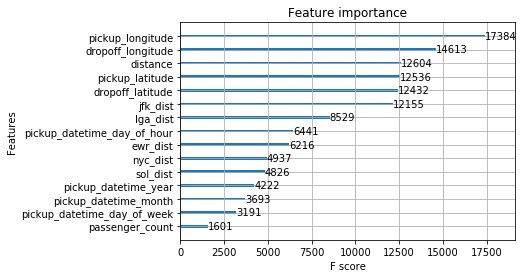

In [64]:
# 説明変数の重要度のグラフ化
xgb.plot_importance(model_xgb)

In [65]:
y_pred = model_xgb.predict(xgb.DMatrix(X_test), ntree_limit = model_xgb.best_ntree_limit)
xgb_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

In [66]:
Regression_evaluator(y_test, y_pred) # 関数呼び出し

平均絶対誤差： 1.5040992556954829
平均絶対誤差： 12.95314980091276
二乗平均平方根誤差： 3.5990484577055586
相関係数 (R)： 0.9266245526914578
決定係数 (R2)： 0.8586330616506443


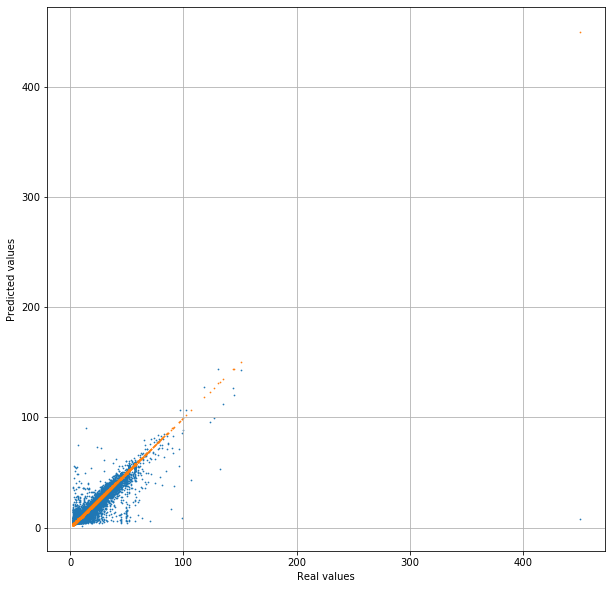

In [67]:
Draw_scatter(y_test, y_pred) # 関数呼び出し

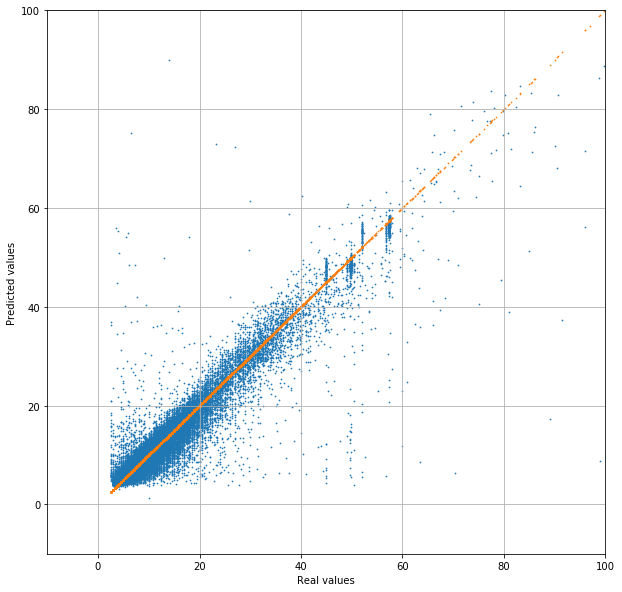

In [68]:
Draw_scatter2(y_test, y_pred) # 関数呼び出し

各アルゴリズムの結果比較 (RMSE)

In [69]:
print("Comparison of RMSE by Algorithms\n")
print("Random Forest: {:.6f} ({:.2f}sec)".format(rf_RMSE, rf_calc_time))
print("CatBoost:      {:.6f} ({:.2f}sec)".format(cat_RMSE, cat_calc_time))
print("lightGBM:      {:.6f} ({:.2f}sec)".format(lgb_RMSE, lgb_calc_time))
print("XGBoost:       {:.6f} ({:.2f}sec)".format(xgb_RMSE, xgb_calc_time))

Comparison of RMSE by Algorithms

Random Forest: 3.639173 (244.52sec)
CatBoost:      3.568814 (336.46sec)
lightGBM:      3.577505 (105.63sec)
XGBoost:       3.599048 (122.68sec)


## 6. Submission

Test データの読み込みと前処理

In [70]:
test_df = pd.read_csv('./data/test.csv')

In [71]:
add_coordinate_features(test_df)
add_airport_dist(test_df)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
test_df['pickup_datetime_month'] = test_df['pickup_datetime'].dt.month
test_df['pickup_datetime_year'] = test_df['pickup_datetime'].dt.year
test_df['pickup_datetime_day_of_week'] = test_df['pickup_datetime'].dt.weekday
test_df['pickup_datetime_day_of_hour'] = test_df['pickup_datetime'].dt.hour

In [72]:
test_df.head()

key           pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002 2015-01-27 13:08:24+00:00        -73.973320   
1  2015-01-27 13:08:24.0000003 2015-01-27 13:08:24+00:00        -73.986862   
2  2011-10-08 11:53:44.0000002 2011-10-08 11:53:44+00:00        -73.982524   
3  2012-12-01 21:12:12.0000002 2012-12-01 21:12:12+00:00        -73.981160   
4  2012-12-01 21:12:12.0000003 2012-12-01 21:12:12+00:00        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.763805         -73.981430         40.743835                1   
1        40.719383         -73.998886         40.739201                1   
2        40.751260         -73.979654         40.746139                1   
3        40.767807         -73.990448         40.751635                1   
4        40.789775         -73.988565         40.744427                1   

   distance   jfk_dist   ewr_dist   lga_dist   sol_dist   nyc_dist  \
0  2.323260  42.055277  35.042878  18.501273  18.309374  10.095252   
1  2.425353  41.244373  30.827012  23.023659  12.664639   4.599471   
2  0.618628  41.831497  33.993679  19.353797  17.018308   8.797452   
3  1.961033  43.964285  34.268523  19.525661  18.544904  10.709378   
4  5.387301  44.128523  36.440152  18.414857  20.732468  12.752865   

   pickup_datetime_month  pickup_datetime_year  pickup_datetime_day_of_week  \
0                      1                  2015                            1   
1                      1                  2015                            1   
2                     10                  2011                            5   
3                     12                  2012                            5   
4                     12                  2012                            5   

   pickup_datetime_day_of_hour  
0                           13  
1                           13  
2                           11  
3                           21  
4                           21

In [73]:
X = pd.DataFrame(test_df.drop(["key","pickup_datetime"], axis=1)) 

In [74]:
X.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.973320        40.763805         -73.981430         40.743835   
1        -73.986862        40.719383         -73.998886         40.739201   
2        -73.982524        40.751260         -73.979654         40.746139   
3        -73.981160        40.767807         -73.990448         40.751635   
4        -73.966046        40.789775         -73.988565         40.744427   

   passenger_count  distance   jfk_dist   ewr_dist   lga_dist   sol_dist  \
0                1  2.323260  42.055277  35.042878  18.501273  18.309374   
1                1  2.425353  41.244373  30.827012  23.023659  12.664639   
2                1  0.618628  41.831497  33.993679  19.353797  17.018308   
3                1  1.961033  43.964285  34.268523  19.525661  18.544904   
4                1  5.387301  44.128523  36.440152  18.414857  20.732468   

    nyc_dist  pickup_datetime_month  pickup_datetime_year  \
0  10.095252                      1                  2015   
1   4.599471                      1                  2015   
2   8.797452                     10                  2011   
3  10.709378                     12                  2012   
4  12.752865                     12                  2012   

   pickup_datetime_day_of_week  pickup_datetime_day_of_hour  
0                            1                           13  
1                            1                           13  
2                            5                           11  
3                            5                           21  
4                            5                           21

In [75]:
# 説明変数（X)のデータ標準化
#X_col = X.columns
#X_std = StandardScaler().fit_transform(X)
#X_std = pd.DataFrame(X_std, index=test_df, columns=X_col)

Random Forest: public score: 3.64783, 776/1483 (52.8%) n=5000000

In [76]:
test_y_predictions_rf = model_rf.predict(X)

In [77]:
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions_rf},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_rf.csv', index = False)

Catboost: public score: 3.09554, 342/1483 (23.0%) n=5000000

In [78]:
test_y_predictions_cat = model_cat.predict(X)

In [79]:
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions_cat},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_cat.csv', index = False)

lightGBM: public score: 3.27501, 501/1483 (33.7%) n=5000000

In [80]:
test_y_predictions_lgb = model_lgb.predict(X)

In [81]:
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions_lgb},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_lgb.csv', index = False)

XGBoost: public score: 3.15268, 394/1483 (26.6%) n=5000000

In [82]:
test_y_predictions_xgb = model_xgb.predict(xgb.DMatrix(X), ntree_limit = model_xgb.best_ntree_limit)

In [83]:
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions_xgb},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_xgb.csv', index = False)

## 7. Ensemble - 平均

In [84]:
df_cat = pd.read_csv('submission_cat.csv')
df_lgb = pd.read_csv('submission_lgb.csv')
df_xgb = pd.read_csv('submission_xgb.csv')

In [85]:
df_cat

key  fare_amount
0     2015-01-27 13:08:24.0000002    10.128108
1     2015-01-27 13:08:24.0000003    11.047009
2     2011-10-08 11:53:44.0000002     4.450357
3     2012-12-01 21:12:12.0000002     9.527998
4     2012-12-01 21:12:12.0000003    16.741339
...                           ...          ...
9909  2015-05-10 12:37:51.0000002     9.445955
9910  2015-01-12 17:05:51.0000001    10.987271
9911  2015-04-19 20:44:15.0000001    52.576009
9912  2015-01-31 01:05:19.0000005    18.732210
9913  2015-01-18 14:06:23.0000006     6.479839

[9914 rows x 2 columns]

In [86]:
df_ensemble = pd.concat([df_cat["fare_amount"], df_lgb["fare_amount"], df_xgb["fare_amount"]], axis=1)
df_ensemble

fare_amount  fare_amount  fare_amount
0       10.128108    10.555132    10.838940
1       11.047009    10.617473    10.817338
2        4.450357     4.421158     4.530861
3        9.527998     9.366065     9.322441
4       16.741339    16.555108    16.673702
...           ...          ...          ...
9909     9.445955     9.093511     9.219808
9910    10.987271    10.596945    11.545120
9911    52.576009    52.475850    54.584305
9912    18.732210    19.119431    19.634790
9913     6.479839     6.899675     6.918400

[9914 rows x 3 columns]

In [87]:
df_ensemble = df_ensemble.mean(axis='columns') # 各行の平均を取る
df_ensemble

0       10.507393
1       10.827274
2        4.467459
3        9.405501
4       16.656716
          ...    
9909     9.253092
9910    11.043112
9911    53.212055
9912    19.162144
9913     6.765971
Length: 9914, dtype: float64

In [88]:
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': df_ensemble},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_ensemble.csv', index = False)

Final RMSE: 3.09331, 341/1483 (23.0%)